In [86]:
import polars as pl
from plotnine import *
from plotnine.themes import theme_set, theme_bw
theme_set(theme_bw())

## SMAG analysis

In [87]:
# SMAG
# ~/m/msingle/mess/138_soil_mags$ head -1 checkm2_qualities.tsv
smag_checkm2 = pl.read_csv("/work/microbiome/msingle/mess/138_soil_mags/checkm2_qualities.tsv", separator='\t', has_header=False)
smag_checkm2.shape, smag_checkm2[0]

# SRR11836440bin.19       52.83   0.03    Neural Network (Specific Model) 11      0.934   47194   313.1221482889734       2112847 0.7     2104    77      103605  None
smag_checkm2.columns = ['bin','completeness','contamination','model','tt','1','2','3','bp','4','5','6','7','8']
smag_checkm2[0]

bin,completeness,contamination,model,tt,1,2,3,bp,4,5,6,7,8
str,f64,f64,str,i64,f64,i64,f64,i64,f64,i64,i64,i64,str
"""SRR11836440bin…",52.83,0.03,"""Neural Network…",11,0.934,47194,313.122148,2112847,0.7,2104,77,103605,"""None"""


In [88]:
smag_filtered = smag_checkm2.filter(pl.col('completeness')>50).filter(pl.col('contamination')<10)
smag_filtered = smag_filtered.with_columns([
    (pl.col('bp') / (pl.col('completeness') / 100) / (1 + pl.col('contamination') / 100)).alias('bp')
])
smag_filtered.select([
    pl.col('bp').mean().alias('mean_bp'),
    pl.col('bp').std().alias('std_bp'),
    pl.col('bp').len().alias('count'),
])
# smag_checkm2.filter(pl.col('completeness')>50).filter(pl.col('contamination')<10).select((pl.col('bp')/(pl.col('completeness')/100)/(1+pl.col('contamination')/100)).mean(), pl.col('bp').len().alias('count'))

mean_bp,std_bp,count
f64,f64,u32
3.9647e6,1.7693e6,19425


In [89]:
# kingfisher = pl.read_csv("../../data/sra/kingfisher_metadata.20220616.csv.gz", separator='\t', infer_schema_length=100000, ignore_errors=True)
# # write ipc
# print("Read {} rows".format(kingfisher.shape[0]))
# # kingfisher.write_ipc('../../data/sra/kingfisher_metadata.20220616.ipc')

In [90]:
def show_all(df, width=200, max_col_width=True):
    '''
    Prints an entire polars dataframe in the console or notebook output.
    Parameters
    ----------
    df : pl.DataFrame
        The dataframe to be printed.
    width : int, optional
        The width of the printed dataframe.
        Defaults to 200.
    max_col_width : bool, optional
        Whether to set the maximum column width.
        i.e. it will print the full contents of the cells.
        Defaults to True.
    '''
    with  pl.Config()  as  cfg:
        cfg.set_tbl_cols(-1)
        cfg.set_tbl_rows(-1)
        cfg.set_tbl_width_chars(width)
        if  max_col_width  or  len(df.columns) ==  1:
            cfg.set_fmt_str_lengths(width)
        print(df)

## Beginnings of rest of analysis

In [91]:
df = pl.read_csv('../../data/sra/acc_organism.csv.gz')
df[:3]

acc,bioproject,organism
str,str,str
"""SRR13213323""","""PRJNA506850""","""manure metagen…"
"""SRR1535388""","""PRJNA256106""","""human gut meta…"
"""SRR1535357""","""PRJNA256106""","""human gut meta…"


In [92]:
# Gather SMF
smf = pl.read_csv('../../data/sra/microbial_fractions.with_ave_genome_size.csv.gz', has_header=True, separator='\t')
smf[:3]

sample,bacterial_archaeal_bases,metagenome_size,read_fraction,average_bacterial_archaeal_genome_size,warning
str,i64,f64,str,i64,str
"""SRR8634435""",1178752140,1.2550e9,"""93.92%""",3419746,null
"""SRR8640623""",1418455610,3.2740e9,"""43.32%""",1941733,null
"""SRR8692214""",7569181622,7.7290e9,"""97.93%""",3353276,null


In [93]:
m = df.join(smf, left_on='acc', right_on='sample', how='inner')
m.shape, m[:3]

((251835, 8),
 shape: (3, 8)
 ┌────────────┬────────────┬────────────┬────────────┬────────────┬───────────┬───────────┬─────────┐
 │ acc        ┆ bioproject ┆ organism   ┆ bacterial_ ┆ metagenome ┆ read_frac ┆ average_b ┆ warning │
 │ ---        ┆ ---        ┆ ---        ┆ archaeal_b ┆ _size      ┆ tion      ┆ acterial_ ┆ ---     │
 │ str        ┆ str        ┆ str        ┆ ases       ┆ ---        ┆ ---       ┆ archaeal_ ┆ str     │
 │            ┆            ┆            ┆ ---        ┆ f64        ┆ str       ┆ genom…    ┆         │
 │            ┆            ┆            ┆ i64        ┆            ┆           ┆ ---       ┆         │
 │            ┆            ┆            ┆            ┆            ┆           ┆ i64       ┆         │
 ╞════════════╪════════════╪════════════╪════════════╪════════════╪═══════════╪═══════════╪═════════╡
 │ SRR1321332 ┆ PRJNA50685 ┆ manure     ┆ 3748652624 ┆ 6.0250e9   ┆ 62.22%    ┆ 3803576   ┆ null    │
 │ 3          ┆ 0          ┆ metagenome ┆            

In [94]:
m = m.with_columns(pl.col('read_fraction').str.replace('%', '').cast(pl.Float64).alias('smf'))
m.shape, m[:3]

((251835, 9),
 shape: (3, 9)
 ┌────────────┬────────────┬────────────┬────────────┬───┬────────────┬───────────┬─────────┬───────┐
 │ acc        ┆ bioproject ┆ organism   ┆ bacterial_ ┆ … ┆ read_fract ┆ average_b ┆ warning ┆ smf   │
 │ ---        ┆ ---        ┆ ---        ┆ archaeal_b ┆   ┆ ion        ┆ acterial_ ┆ ---     ┆ ---   │
 │ str        ┆ str        ┆ str        ┆ ases       ┆   ┆ ---        ┆ archaeal_ ┆ str     ┆ f64   │
 │            ┆            ┆            ┆ ---        ┆   ┆ str        ┆ genom…    ┆         ┆       │
 │            ┆            ┆            ┆ i64        ┆   ┆            ┆ ---       ┆         ┆       │
 │            ┆            ┆            ┆            ┆   ┆            ┆ i64       ┆         ┆       │
 ╞════════════╪════════════╪════════════╪════════════╪═══╪════════════╪═══════════╪═════════╪═══════╡
 │ SRR1321332 ┆ PRJNA50685 ┆ manure     ┆ 3748652624 ┆ … ┆ 62.22%     ┆ 3803576   ┆ null    ┆ 62.22 │
 │ 3          ┆ 0          ┆ metagenome ┆            

In [95]:
# Filter rows based on NCBI method metadata
# ncbi_method <- read_delim("data/sra/NCBI_method_taxonomy_processed.csv.gz")
#   filter(library_strategy == "WGS" & library_selection == "RANDOM") %>%
#   filter(gbp > 0.5) 
extra_metadata = pl.read_csv('../../data/sra/extra_metadata_short.tsv.gz', separator='\t', null_values=['NA','null'])
# print(extra_metadata.shape)
# show_all(extra_metadata[:3])
extra_metadata = extra_metadata.filter(pl.col('library_strategy') == 'WGS').filter(pl.col('library_selection') == 'RANDOM').filter(pl.col('Gbp') > 0.5)
# print("Found {} SRA runs that pass the metadata filtering".format(extra_metadata.shape[0]))
original_smf_count = m.shape[0]
m = m.join(extra_metadata, left_on='acc', right_on='run', how='inner')
print("Found {} SRA runs that pass the metadata filtering out of {} original".format(m.shape[0], original_smf_count))

Found 136284 SRA runs that pass the metadata filtering out of 251835 original


In [96]:
lat_lon = pl.read_csv('../../data/sra/sandpiper_21_parsed_sample_attributes.tsv.gz', separator='\t')
lat_lon[:3]

acc,id,run_id,collection_year,collection_month,latitude,longitude,depth,temperature,host_or_not_prediction,host_or_not_recorded,host_or_not_mature
str,i64,i64,i64,i64,f64,f64,f64,f64,str,str,str
"""SRR13213323""",1,1,2016,6,37.200236,-80.564449,null,null,"""ecological""","""ecological""","""ecological"""
"""SRR1535388""",2,2,2013,1,22.55,113.24,null,null,"""host""","""host""","""host"""
"""SRR1535357""",3,3,2012,1,22.55,113.24,null,null,"""host""","""host""","""host"""


In [97]:
soils = m.filter(pl.col('organism')=='soil metagenome')
soils.shape, soils[:3]

((4655, 16),
 shape: (3, 16)
 ┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
 │ acc       ┆ bioprojec ┆ organism  ┆ bacterial ┆ … ┆ library_s ┆ model     ┆ sample_na ┆ taxon_na │
 │ ---       ┆ t         ┆ ---       ┆ _archaeal ┆   ┆ election  ┆ ---       ┆ me        ┆ me       │
 │ str       ┆ ---       ┆ str       ┆ _bases    ┆   ┆ ---       ┆ str       ┆ ---       ┆ ---      │
 │           ┆ str       ┆           ┆ ---       ┆   ┆ str       ┆           ┆ str       ┆ str      │
 │           ┆           ┆           ┆ i64       ┆   ┆           ┆           ┆           ┆          │
 ╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
 │ ERR174226 ┆ PRJEB8420 ┆ soil meta ┆ 914834837 ┆ … ┆ RANDOM    ┆ HiSeq X   ┆ SL-WGS-OM ┆ soil met │
 │ 3         ┆           ┆ genome    ┆ 9         ┆   ┆           ┆ Ten       ┆ 3-Bt-3    ┆ agenome  │
 │ SRR747173 ┆ PRJNA4645 ┆ soil meta ┆ 491501756 ┆ … 

In [98]:
sll = soils.join(lat_lon, on='acc', how='inner')
sll.shape, sll[:3]

((4630, 27),
 shape: (3, 27)
 ┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
 │ acc       ┆ bioprojec ┆ organism  ┆ bacterial ┆ … ┆ temperatu ┆ host_or_n ┆ host_or_n ┆ host_or_ │
 │ ---       ┆ t         ┆ ---       ┆ _archaeal ┆   ┆ re        ┆ ot_predic ┆ ot_record ┆ not_matu │
 │ str       ┆ ---       ┆ str       ┆ _bases    ┆   ┆ ---       ┆ tion      ┆ ed        ┆ re       │
 │           ┆ str       ┆           ┆ ---       ┆   ┆ f64       ┆ ---       ┆ ---       ┆ ---      │
 │           ┆           ┆           ┆ i64       ┆   ┆           ┆ str       ┆ str       ┆ str      │
 ╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
 │ ERR174226 ┆ PRJEB8420 ┆ soil meta ┆ 914834837 ┆ … ┆ null      ┆ ecologica ┆ ecologica ┆ ecologic │
 │ 3         ┆           ┆ genome    ┆ 9         ┆   ┆           ┆ l         ┆ l         ┆ al       │
 │ SRR747173 ┆ PRJNA4645 ┆ soil meta ┆ 491501756 ┆ … 

In [99]:
# Are metagenomes with <5% SMF bad data / analysis?
sll.filter(~pl.col('latitude').is_null()).filter(pl.col('smf')<5).sample(10)
# => mtDNA, E. coli only, targeted metagenomics, etc. yeh, they bad.

acc,bioproject,organism,bacterial_archaeal_bases,metagenome_size,read_fraction,average_bacterial_archaeal_genome_size,warning,smf,bioproject_right,Gbp,library_strategy,library_selection,model,sample_name,taxon_name,id,run_id,collection_year,collection_month,latitude,longitude,depth,temperature,host_or_not_prediction,host_or_not_recorded,host_or_not_mature
str,str,str,i64,f64,str,i64,str,f64,str,f64,str,str,str,str,str,i64,i64,i64,i64,f64,f64,f64,f64,str,str,str
"""SRR3984945""","""PRJNA330045""","""soil metagenom…",11613861,6.14e8,"""1.89%""",4859356,null,1.89,"""PRJNA330045""",0.615,"""WGS""","""RANDOM""","""Illumina HiSeq…","""NNNC""","""soil metagenom…",114863,114863,null,null,-2.4196,-55.8163,null,null,"""host""","""ecological""","""ecological"""
"""SRR3984908""","""PRJNA330045""","""soil metagenom…",15127510,7.03e8,"""2.15%""",4727347,null,2.15,"""PRJNA330045""",0.704,"""WGS""","""RANDOM""","""Illumina HiSeq…","""NNOS""","""soil metagenom…",89445,89445,null,null,-2.4196,-55.8163,null,null,"""host""","""ecological""","""ecological"""
"""SRR3984925""","""PRJNA330045""","""soil metagenom…",19846990,8.23e8,"""2.41%""",4520954,null,2.41,"""PRJNA330045""",0.824,"""WGS""","""RANDOM""","""Illumina HiSeq…","""NNON""","""soil metagenom…",162705,162705,null,null,-2.4196,-55.8163,null,null,"""host""","""ecological""","""ecological"""
"""SRR3984953""","""PRJNA330045""","""soil metagenom…",5127355,1.1340e9,"""0.45%""",4497680,null,0.45,"""PRJNA330045""",1.134,"""WGS""","""RANDOM""","""Illumina HiSeq…","""NGCZ""","""soil metagenom…",175317,175317,null,null,-2.4196,-55.8163,null,null,"""host""","""ecological""","""ecological"""
"""SRR8487022""","""PRJNA646773""","""soil metagenom…",153946094,4.1300e9,"""3.73%""",2234341,null,3.73,"""PRJNA646773""",4.131,"""WGS""","""RANDOM""","""Illumina HiSeq…","""AlmondShellBio…","""soil metagenom…",62359,62359,2018,4,38.535556,-121.772778,null,null,"""ecological""","""ecological""","""ecological"""
"""SRR16123990""","""PRJNA767554""","""soil metagenom…",157237335,1.2832e10,"""1.23%""",2869818,null,1.23,"""PRJNA767554""",12.833,"""WGS""","""RANDOM""","""Illumina NovaS…","""RR452Oct_vir_c…","""soil metagenom…",105915,105915,2018,10,38.543123,-121.874259,null,null,"""ecological""","""ecological""","""ecological"""
"""SRR16123985""","""PRJNA767554""","""soil metagenom…",308149553,1.3557e10,"""2.27%""",2560232,null,2.27,"""PRJNA767554""",13.558,"""WGS""","""RANDOM""","""Illumina NovaS…","""RR642July_vir_…","""soil metagenom…",166392,166392,2018,7,38.541763,-121.875162,null,null,"""ecological""","""ecological""","""ecological"""
"""SRR8487019""","""PRJNA646773""","""soil metagenom…",153567014,3.6800e9,"""4.17%""",2278104,null,4.17,"""PRJNA646773""",3.68,"""WGS""","""RANDOM""","""Illumina HiSeq…","""AlmondShellBio…","""soil metagenom…",116505,116505,2018,4,38.535556,-121.772778,null,null,"""ecological""","""ecological""","""ecological"""
"""SRR8487018""","""PRJNA646773""","""soil metagenom…",58719166,4.4080e9,"""1.33%""",3870743,null,1.33,"""PRJNA646773""",4.408,"""WGS""","""RANDOM""","""Illumina HiSeq…","""PineBiochar_Hi…","""soil metagenom…",240272,240272,2018,8,38.535556,-121.772778,null,null,"""ecological""","""ecological""","""ecological"""


In [100]:
# Apply filter for the rest of the analysis
sll = sll.filter(pl.col('smf')>=5)

sll = sll.filter(~pl.col('latitude').is_null()).filter(pl.col('smf')>5)

# Overall soil stats

In [101]:
sll.select(pl.col('smf').median().alias('median_smf'), pl.col('smf').mean().alias('mean_smf'), pl.col('smf').std().alias('std_smf'))

median_smf,mean_smf,std_smf
f64,f64,f64
68.98,67.119417,15.096887


# Latitude analysis

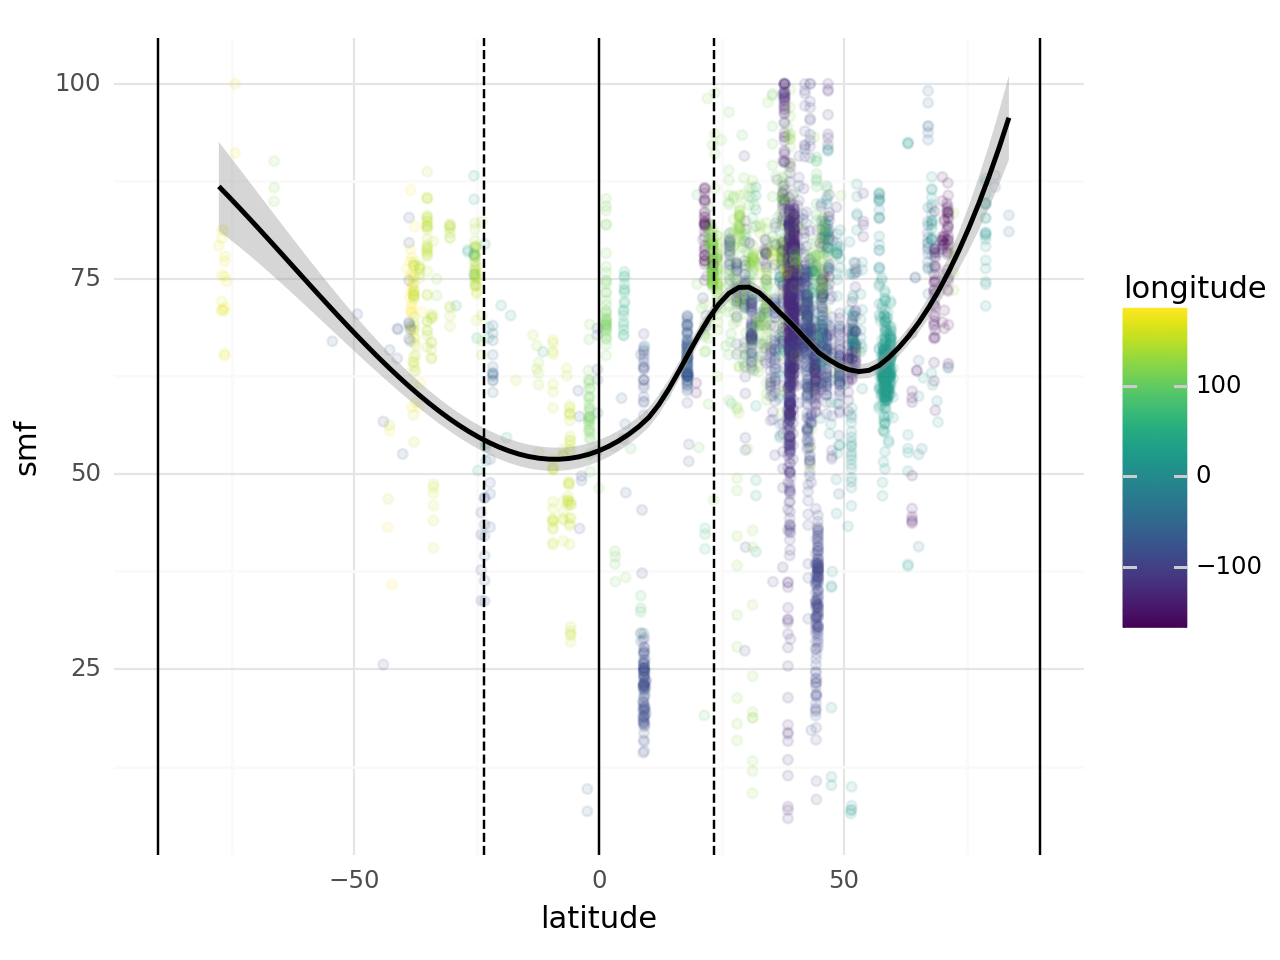

<Figure Size: (640 x 480)>

In [102]:
tropic = 23.43614

ggplot(sll)+geom_point(aes(x='latitude', y='smf', colour='longitude'), alpha=0.1)+geom_smooth(aes(x='latitude', y='smf'), method='loess')+theme_minimal()+geom_vline(xintercept=[0, -90, 90])+geom_vline(xintercept=[-tropic,tropic], linetype='dashed')

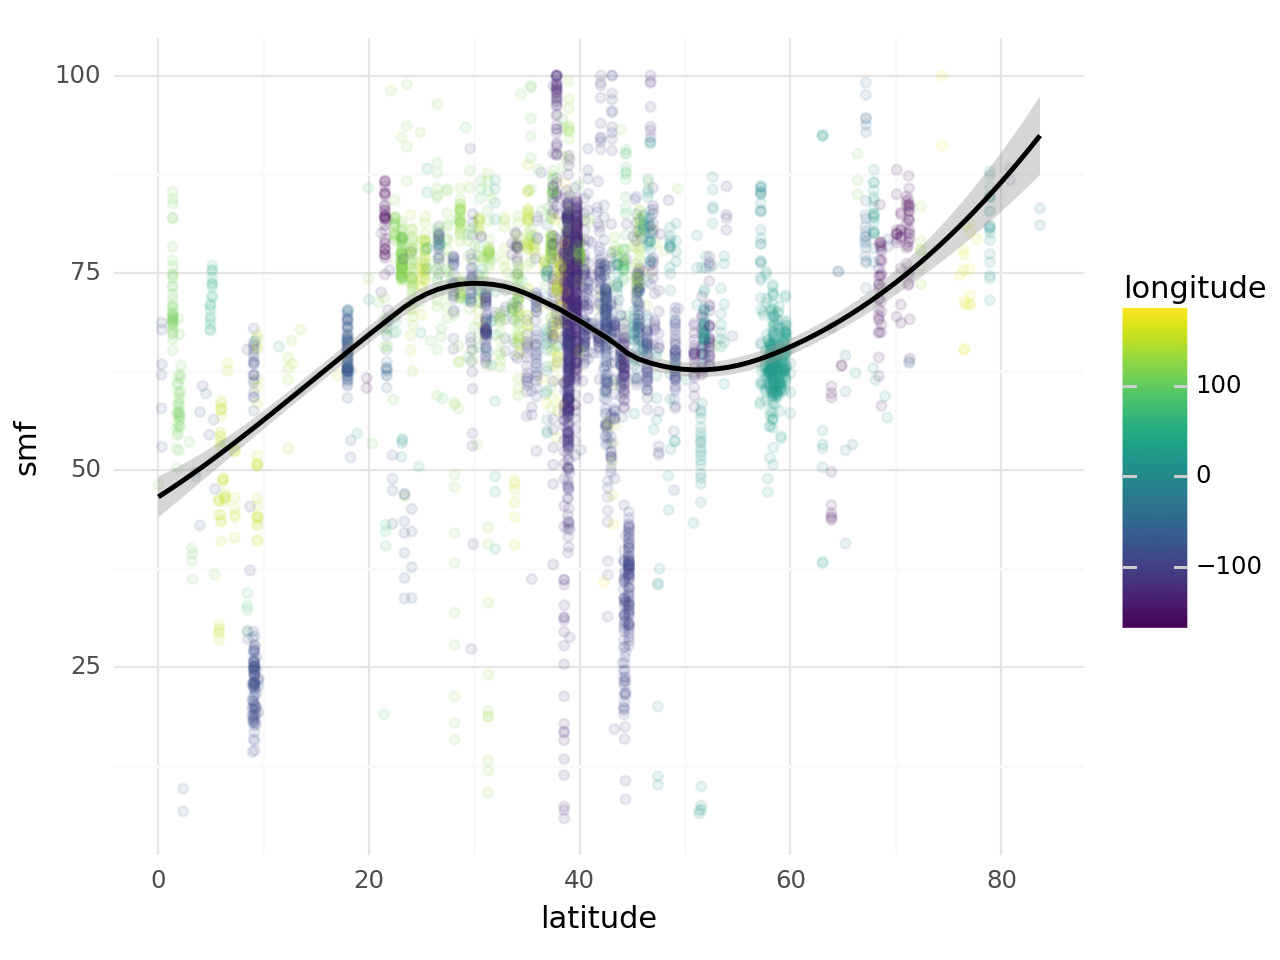

<Figure Size: (640 x 480)>

In [103]:
ggplot(sll.filter(~pl.col('latitude').is_null()).filter(pl.col('smf')>5).with_columns(pl.col('latitude').abs()))+geom_point(aes(x='latitude', y='smf', colour='longitude'), alpha=0.1)+geom_smooth(aes(x='latitude', y='smf'), method='loess')+theme_minimal()

In [104]:
# t-test of how different the two are
from scipy.stats import ttest_ind
ttest_ind(
    sll.filter(pl.col('latitude').abs() < tropic).select(pl.col('smf')).to_pandas(),
    sll.filter(pl.col('latitude').abs() > tropic).select(pl.col('smf')).to_pandas())

TtestResult(statistic=array([-16.49030956]), pvalue=array([3.87875123e-59]), df=array([3958.]))

In [105]:
# mean and sd of the two
print(sll.filter(pl.col('latitude').abs() < tropic).select(pl.col('smf').mean(), pl.col('smf').std().alias('std'), pl.col('smf').median().alias('median')))
print(sll.filter(pl.col('latitude').abs() > tropic).select(pl.col('smf').mean(), pl.col('smf').std().alias('std'), pl.col('smf').median().alias('median')))

shape: (1, 3)
┌───────────┬───────────┬────────┐
│ smf       ┆ std       ┆ median │
│ ---       ┆ ---       ┆ ---    │
│ f64       ┆ f64       ┆ f64    │
╞═══════════╪═══════════╪════════╡
│ 57.698592 ┆ 19.630856 ┆ 62.98  │
└───────────┴───────────┴────────┘
shape: (1, 3)
┌──────────┬───────────┬────────┐
│ smf      ┆ std       ┆ median │
│ ---      ┆ ---       ┆ ---    │
│ f64      ┆ f64       ┆ f64    │
╞══════════╪═══════════╪════════╡
│ 68.67431 ┆ 13.600112 ┆ 69.95  │
└──────────┴───────────┴────────┘


In [106]:
# Write out the data the plot can be incorporated into the figure generated in R
# ggplot(sll)+geom_point(aes(x='latitude', y='smf', colour='longitude'), alpha=0.1)+geom_smooth(aes(x='latitude', y='smf'), method='loess')+theme_minimal()+geom_vline(xintercept=[0, -90, 90])+geom_vline(xintercept=[-tropic,tropic], linetype='dashed')
sll.select('latitude', 'longitude', 'smf').write_csv('smf_vs_latitude.generated.csv')

# bacteria : fungi ratios

## What is the average genome size of Ascomycota?

In [107]:
# From https://www.ncbi.nlm.nih.gov/datasets/genome/?taxon=4890
fungi_genomes = pl.read_csv('ascomycota_genome_stats.csv', separator='\t')
fungi_genomes.shape, fungi_genomes[:3]

((14723, 14),
 shape: (3, 14)
 ┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
 │ Assembly  ┆ Assembly  ┆ Organism  ┆ Organism  ┆ … ┆ Assembly  ┆ Assembly  ┆ Assembly  ┆ WGS      │
 │ Accession ┆ Name      ┆ Name      ┆ Infraspec ┆   ┆ Stats     ┆ Level     ┆ Release   ┆ project  │
 │ ---       ┆ ---       ┆ ---       ┆ ific      ┆   ┆ Total     ┆ ---       ┆ Date      ┆ accessio │
 │ str       ┆ str       ┆ str       ┆ Names     ┆   ┆ Sequence  ┆ str       ┆ ---       ┆ n        │
 │           ┆           ┆           ┆ Bre…      ┆   ┆ Le…       ┆           ┆ str       ┆ ---      │
 │           ┆           ┆           ┆ ---       ┆   ┆ ---       ┆           ┆           ┆ str      │
 │           ┆           ┆           ┆ str       ┆   ┆ i64       ┆           ┆           ┆          │
 ╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
 │ GCA_00014 ┆ R64       ┆ Saccharom ┆ null      ┆ …

In [108]:
# Pick median genome size per genus
fungi_genomes = fungi_genomes.with_columns(pl.col('Organism Name').str.split(' ').list.get(0).alias('genus'))
fungi_genomes[:3]
genus_medians = fungi_genomes.group_by('genus').agg(pl.col('Assembly Stats Total Sequence Length').median().alias('median_genome_size'))
fungal_genome_size_estimate = genus_medians.select(pl.col('median_genome_size').mean())[0,0]
fungal_genome_size_estimate / 1e6

37.473274544375

In [109]:
# Get the median smf
median_smf = sll.select(pl.col('smf').median())[0,0]
median_smf = median_smf / 100
median_smf

0.6898000000000001

## Calculate cellular ratio

In [110]:
bacterial_genome_size_estimate = sll.select(pl.col('average_bacterial_archaeal_genome_size').mean())[0,0]
bacterial_genome_size_estimate

4456486.233333333

In [111]:
# At 75%, what is the average relabund of fungi in soil metagenomes, assuming they are only bacteria and fungi, and all fungi are extracted

def bacterial_to_fungi_cell_relabund(
    bacterial_genome_size_estimate,
    fungal_genome_size_estimate,
    bacterial_relabund):

    ratio = bacterial_relabund / ( (bacterial_genome_size_estimate / fungal_genome_size_estimate) * (1 - bacterial_relabund) )

    relabund = ratio / (1 + ratio)

    # Report relabund of bacterial cells, and the ratio of fungi to bacteria
    return relabund, 1/ratio

b, r = bacterial_to_fungi_cell_relabund(bacterial_genome_size_estimate, fungal_genome_size_estimate, median_smf)
print(b, r)

# => 95% of cells are bacterial. 5% are fungal. This is a rough estimate, but it potentially in the right ballpark.

# What if we are under-doing it by 5%?
print(bacterial_to_fungi_cell_relabund(bacterial_genome_size_estimate, fungal_genome_size_estimate, median_smf + 0.05))
# => 96%.


0.94923512423291 0.05347976962832446
(0.959851623037089, 0.04182769086317375)


In [112]:
# Quantiles
q10 = sll.select(pl.col('smf').quantile(0.1))[0,0] / 100
print(q10)
print(bacterial_to_fungi_cell_relabund(
    bacterial_genome_size_estimate,
    fungal_genome_size_estimate,
    q10))

# Quantiles
q90 = sll.select(pl.col('smf').quantile(0.9))[0,0] / 100
print(q90)
print(bacterial_to_fungi_cell_relabund(
    bacterial_genome_size_estimate,
    fungal_genome_size_estimate,
    q90))


0.47869999999999996
(0.8853415495581336, 0.129507590035836)
0.8184
(0.9742895780154532, 0.026388891521262843)


In [113]:
# Median within 20 of the equator vs outside
median_within_20 = sll.filter(pl.col('latitude').abs() < tropic).select(pl.col('smf').median())[0,0] / 100
print(median_within_20)
print(bacterial_to_fungi_cell_relabund(
    bacterial_genome_size_estimate,
    fungal_genome_size_estimate,
    median_within_20))

median_outside_20 = sll.filter(pl.col('latitude').abs() > tropic).select(pl.col('smf').median())[0,0] / 100
print(median_outside_20)
print(bacterial_to_fungi_cell_relabund(
    bacterial_genome_size_estimate,
    fungal_genome_size_estimate,
    median_outside_20))

0.6297999999999999
(0.9346629235471813, 0.06990442736816284)
0.6995
(0.9513941908623168, 0.05108903292086351)


In [114]:
# Percent which had >50% SMF
sll.filter(pl.col('smf') > 50).shape[0] / sll.shape[0] * 100

89.29292929292929

In [115]:
sll.shape

(3960, 27)

# Example runs from within and outside the tropics

In [116]:
sll.filter(pl.col('latitude').abs() < tropic).sample(10)

acc,bioproject,organism,bacterial_archaeal_bases,metagenome_size,read_fraction,average_bacterial_archaeal_genome_size,warning,smf,bioproject_right,Gbp,library_strategy,library_selection,model,sample_name,taxon_name,id,run_id,collection_year,collection_month,latitude,longitude,depth,temperature,host_or_not_prediction,host_or_not_recorded,host_or_not_mature
str,str,str,i64,f64,str,i64,str,f64,str,f64,str,str,str,str,str,i64,i64,i64,i64,f64,f64,f64,f64,str,str,str
"""ERR1877897""","""PRJEB18701""","""soil metagenom…",273518429,6.17e8,"""44.33%""",4986662,null,44.33,"""PRJEB18701""",0.618,"""WGS""","""RANDOM""","""Illumina HiSeq…","""G2700""","""soil metagenom…",62353,62353,null,null,-5.79035,145.05771,null,null,"""ecological""","""ecological""","""ecological"""
"""SRR10011746""","""PRJNA554847""","""soil metagenom…",343828383,1.3850e9,"""24.83%""",4338528,null,24.83,"""PRJNA554847""",1.386,"""WGS""","""RANDOM""","""NextSeq 500""","""LP_0404_SM""","""soil metagenom…",78689,78689,2017,1,9.12,-79.9,null,null,"""ecological""","""ecological""","""ecological"""
"""SRR7468582""","""PRJNA464504""","""soil metagenom…",3895913270,6.2220e9,"""62.62%""",4689634,null,62.62,"""PRJNA464504""",6.223,"""WGS""","""RANDOM""","""Illumina HiSeq…","""GNXO""","""soil metagenom…",48342,48342,2009,5,18.0,-65.0,null,null,"""ecological""","""ecological""","""ecological"""
"""SRR10011759""","""PRJNA554847""","""soil metagenom…",278512941,1.4810e9,"""18.81%""",4034081,null,18.81,"""PRJNA554847""",1.481,"""WGS""","""RANDOM""","""NextSeq 500""","""Cla_tr0105_SM""","""soil metagenom…",59558,59558,2017,1,9.0,-79.57,null,null,"""ecological""","""ecological""","""ecological"""
"""SRR5215469""","""PRJNA364909""","""soil metagenom…",31119111799,5.2602e10,"""59.16%""",5123964,null,59.16,"""PRJNA364909""",52.603,"""WGS""","""RANDOM""","""Illumina HiSeq…","""BAWXW""","""soil metagenom…",16533,16533,2016,2,9.1086,-79.8436,null,null,"""ecological""","""ecological""","""ecological"""
"""SRR8936461""","""PRJNA528368""","""soil metagenom…",6895155661,8.9870e9,"""76.72%""",4556702,null,76.72,"""PRJNA528368""",8.987,"""WGS""","""RANDOM""","""HiSeq X Ten""","""Metagenome of …","""soil metagenom…",99202,99202,2018,9,23.14,113.34,null,null,"""ecological""","""ecological""","""ecological"""
"""SRR3984901""","""PRJNA330045""","""soil metagenom…",52586387,7.78e8,"""6.76%""",4754646,null,6.76,"""PRJNA330045""",0.779,"""WGS""","""RANDOM""","""Illumina HiSeq…","""NGAC""","""soil metagenom…",175312,175312,null,null,-2.4196,-55.8163,null,null,"""host""","""ecological""","""ecological"""
"""SRR10586123""","""PRJNA593573""","""soil metagenom…",2014036328,2.9300e9,"""68.74%""",4371782,null,68.74,"""PRJNA593573""",2.93,"""WGS""","""RANDOM""","""Illumina HiSeq…","""KLBSR2G""","""soil metagenom…",210676,210676,2018,3,1.42,103.7,null,null,"""ecological""","""ecological""","""ecological"""
"""SRR12095479""","""PRJNA641804""","""soil metagenom…",10874181221,2.0609e10,"""52.76%""",4550990,null,52.76,"""PRJNA641804""",20.61,"""WGS""","""RANDOM""","""NextSeq 500""","""Mn_soil_metage…","""soil metagenom…",210570,210570,2016,4,-12.37,130.867,null,null,"""ecological""","""ecological""","""ecological"""


In [117]:
sll.filter(pl.col('latitude').abs() > tropic).sample(10)

acc,bioproject,organism,bacterial_archaeal_bases,metagenome_size,read_fraction,average_bacterial_archaeal_genome_size,warning,smf,bioproject_right,Gbp,library_strategy,library_selection,model,sample_name,taxon_name,id,run_id,collection_year,collection_month,latitude,longitude,depth,temperature,host_or_not_prediction,host_or_not_recorded,host_or_not_mature
str,str,str,i64,f64,str,i64,str,f64,str,f64,str,str,str,str,str,i64,i64,i64,i64,f64,f64,f64,f64,str,str,str
"""SRR12736056""","""PRJNA666221""","""soil metagenom…",13457251633,2.3431e10,"""57.43%""",4551859,null,57.43,"""PRJNA666221""",23.431,"""WGS""","""RANDOM""","""Illumina NovaS…","""SPR2-1_virome_…","""soil metagenom…",81536,81536,2018,8,47.5078,-93.4524,null,null,"""ecological""","""ecological""","""ecological"""
"""ERR4837109""","""PRJEB41174""","""soil metagenom…",1472361975,1.6760e9,"""87.85%""",3838374,null,87.85,"""PRJEB41174""",1.676,"""WGS""","""RANDOM""","""Illumina MiSeq…","""SV5""","""soil metagenom…",109321,109321,2013,1,78.896172,12.062216,null,null,"""ecological""","""ecological""","""ecological"""
"""SRR12659391""","""PRJNA654933""","""soil metagenom…",51517009256,7.3238e10,"""70.34%""",5103215,null,70.34,"""PRJNA654933""",73.238,"""WGS""","""RANDOM""","""Illumina NovaS…","""GPAZU""","""soil metagenom…",150018,150018,2017,10,42.5315,-72.1899,null,null,"""ecological""","""ecological""","""ecological"""
"""SRR7042385""","""PRJNA449266""","""soil metagenom…",13610234083,1.7267e10,"""78.82%""",4318159,null,78.82,"""PRJNA449266""",17.267,"""WGS""","""RANDOM""","""Illumina HiSeq…","""14_0903_09_40c…","""soil metagenom…",201265,201265,2014,9,39.74,-123.63,null,null,"""ecological""","""ecological""","""ecological"""
"""SRR6266704""","""PRJNA406082""","""soil metagenom…",16946737873,2.4534e10,"""69.07%""",4291128,null,69.07,"""PRJNA406082""",24.534,"""WGS""","""RANDOM""","""Illumina HiSeq…","""BGYZY""","""soil metagenom…",45040,45040,2016,6,39.5673,-123.4758,null,null,"""ecological""","""ecological""","""ecological"""
"""SRR9733667""","""PRJNA555481""","""soil metagenom…",587759633,8.59e8,"""68.42%""",4335790,null,68.42,"""PRJNA555481""",0.86,"""WGS""","""RANDOM""","""Illumina MiSeq…","""JC3""","""soil metagenom…",62260,62260,2016,3,53.4,16.3,null,null,"""ecological""","""ecological""","""ecological"""
"""SRR7968837""","""PRJNA469299""","""soil metagenom…",6902826699,1.0980e10,"""62.87%""",4809662,null,62.87,"""PRJNA469299""",10.981,"""WGS""","""RANDOM""","""Illumina HiSeq…","""CNWON""","""soil metagenom…",41910,41910,2017,7,44.23,-122.22,null,null,"""ecological""","""ecological""","""ecological"""
"""SRR5381903""","""PRJNA378500""","""soil metagenom…",1307612790,1.7200e9,"""76.02%""",4201976,null,76.02,"""PRJNA378500""",1.72,"""WGS""","""RANDOM""","""Illumina HiSeq…","""C2""","""soil metagenom…",8290,8290,2016,9,43.577,4.368,null,null,"""ecological""","""ecological""","""ecological"""
"""SRR8554485""","""PRJNA518247""","""soil metagenom…",55132500721,5.9692e10,"""92.36%""",3421253,null,92.36,"""PRJNA518247""",59.693,"""WGS""","""RANDOM""","""Illumina NovaS…","""CWAHP""","""soil metagenom…",70390,70390,2017,8,63.0472,21.7116,null,null,"""ecological""","""ecological""","""ecological"""


In [118]:
# What about minus the samples from https://sandpiper.qut.edu.au/project?model_bioproject=PRJNA554847 ?
to_test = sll.filter(~(pl.col('bioproject')=='PRJNA554847'))
ttest_ind(
    to_test.filter(pl.col('latitude').abs() < tropic).select(pl.col('smf')).to_pandas(),
    to_test.filter(pl.col('latitude').abs() > tropic).select(pl.col('smf')).to_pandas())
# p-value 5e-11, so still sig.

TtestResult(statistic=array([-6.35299889]), pvalue=array([2.35778524e-10]), df=array([3847.]))

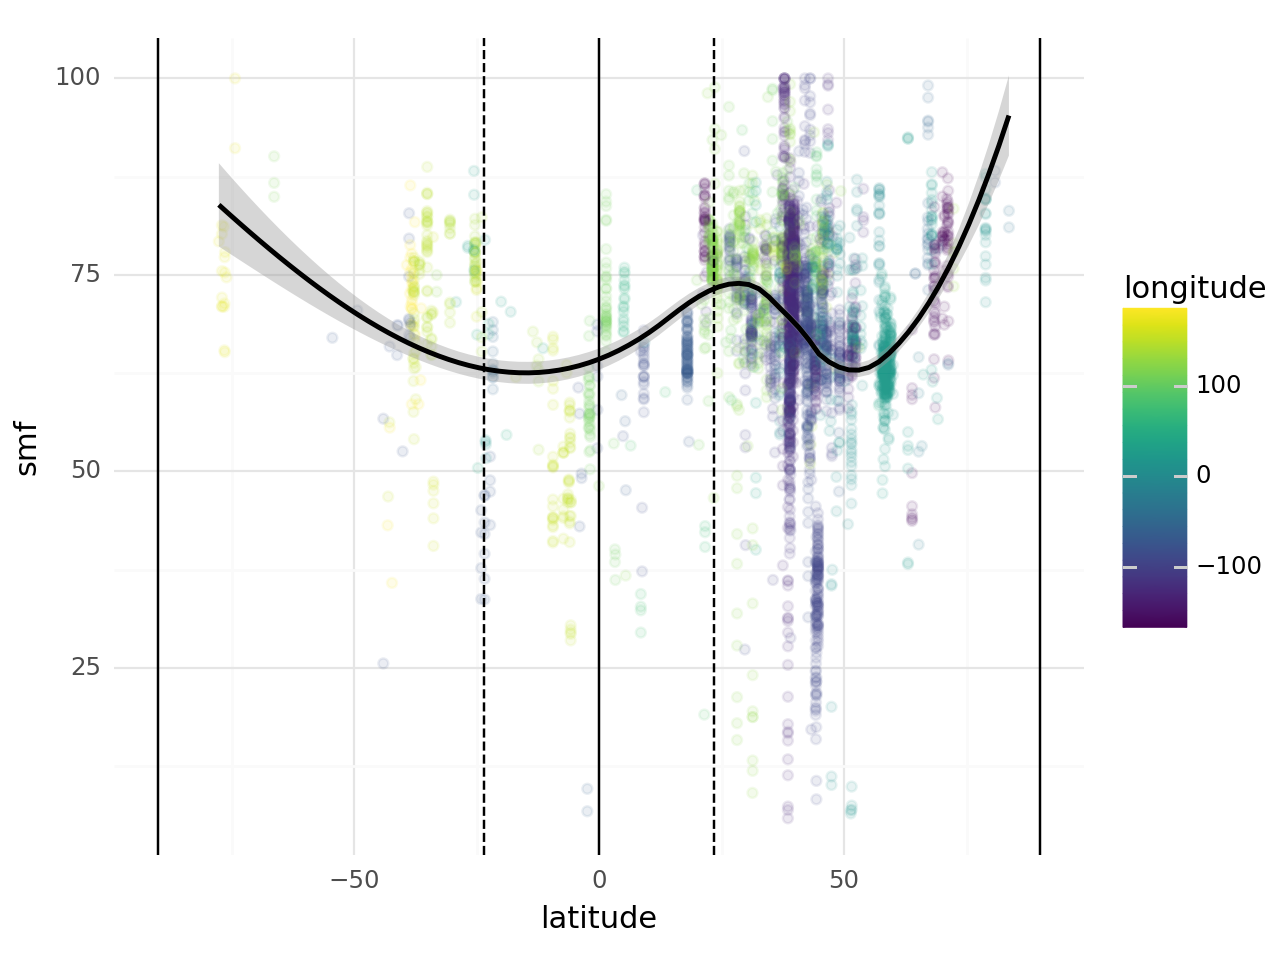

<Figure Size: (640 x 480)>

In [119]:
ggplot(to_test)+geom_point(aes(x='latitude', y='smf', colour='longitude'), alpha=0.1)+geom_smooth(aes(x='latitude', y='smf'), method='loess')+theme_minimal()+geom_vline(xintercept=[0, -90, 90])+geom_vline(xintercept=[-tropic,tropic], linetype='dashed')

In [120]:
to_test.filter(pl.col('latitude').abs() < tropic).filter(pl.col('smf')<65).sample(10)

acc,bioproject,organism,bacterial_archaeal_bases,metagenome_size,read_fraction,average_bacterial_archaeal_genome_size,warning,smf,bioproject_right,Gbp,library_strategy,library_selection,model,sample_name,taxon_name,id,run_id,collection_year,collection_month,latitude,longitude,depth,temperature,host_or_not_prediction,host_or_not_recorded,host_or_not_mature
str,str,str,i64,f64,str,i64,str,f64,str,f64,str,str,str,str,str,i64,i64,i64,i64,f64,f64,f64,f64,str,str,str
"""SRR7468330""","""PRJNA464489""","""soil metagenom…",7836256804,1.2468e10,"""62.85%""",4954639,null,62.85,"""PRJNA464489""",12.469,"""WGS""","""RANDOM""","""Illumina HiSeq…","""HBPP""","""soil metagenom…",89497,89497,2009,5,18.0,-65.0,null,null,"""ecological""","""ecological""","""ecological"""
"""SRR7471415""","""PRJNA464503""","""soil metagenom…",5050410583,7.8090e9,"""64.67%""",4811885,null,64.67,"""PRJNA464503""",7.809,"""WGS""","""RANDOM""","""Illumina HiSeq…","""HBUO""","""soil metagenom…",175334,175334,2011,8,18.0,-65.0,null,null,"""ecological""","""ecological""","""ecological"""
"""ERR1877806""","""PRJEB18701""","""soil metagenom…",584681518,1.2700e9,"""46.04%""",5248959,null,46.04,"""PRJEB18701""",1.27,"""WGS""","""RANDOM""","""Illumina HiSeq…","""G2736""","""soil metagenom…",237133,237133,null,null,-6.3755,145.255833,null,null,"""ecological""","""ecological""","""ecological"""
"""ERR1877680""","""PRJEB18701""","""soil metagenom…",1159778804,2.0080e9,"""57.76%""",4904757,null,57.76,"""PRJEB18701""",2.008,"""WGS""","""RANDOM""","""Illumina HiSeq…","""G2677""","""soil metagenom…",233919,233919,null,null,-6.01732,145.41601,null,null,"""ecological""","""ecological""","""ecological"""
"""SRR10028488""","""PRJNA562410""","""soil metagenom…",3302207369,5.7950e9,"""56.98%""",5112093,null,56.98,"""PRJNA562410""",5.795,"""WGS""","""RANDOM""","""Illumina HiSeq…","""SoilSampleHO4""","""soil metagenom…",164097,164097,2012,10,-1.786861,103.270556,null,null,"""ecological""","""ecological""","""ecological"""
"""SRR7471732""","""PRJNA464507""","""soil metagenom…",5141314339,8.2190e9,"""62.55%""",4811847,null,62.55,"""PRJNA464507""",8.219,"""WGS""","""RANDOM""","""Illumina HiSeq…","""HBTZ""","""soil metagenom…",73621,73621,2011,8,18.0,-65.0,null,null,"""ecological""","""ecological""","""ecological"""
"""ERR1877660""","""PRJEB18701""","""soil metagenom…",270470368,5.44e8,"""49.72%""",5046089,null,49.72,"""PRJEB18701""",0.545,"""WGS""","""RANDOM""","""Illumina HiSeq…","""AV105""","""soil metagenom…",167422,167422,null,null,-3.598,-69.53,null,null,"""ecological""","""ecological""","""ecological"""
"""ERR1877823""","""PRJEB18701""","""soil metagenom…",865919847,2.0080e9,"""43.12%""",5007922,null,43.12,"""PRJEB18701""",2.008,"""WGS""","""RANDOM""","""Illumina HiSeq…","""G2657""","""soil metagenom…",2144,2144,null,null,-9.44475,147.34958,null,null,"""ecological""","""ecological""","""ecological"""
"""SRR10028497""","""PRJNA562410""","""soil metagenom…",2972128306,4.9550e9,"""59.98%""",5316106,null,59.98,"""PRJNA562410""",4.956,"""WGS""","""RANDOM""","""Illumina HiSeq…","""SoilSampleHF4""","""soil metagenom…",11547,11547,2012,11,-2.187556,103.342611,null,null,"""ecological""","""ecological""","""ecological"""


# Bioproject-specific analyses

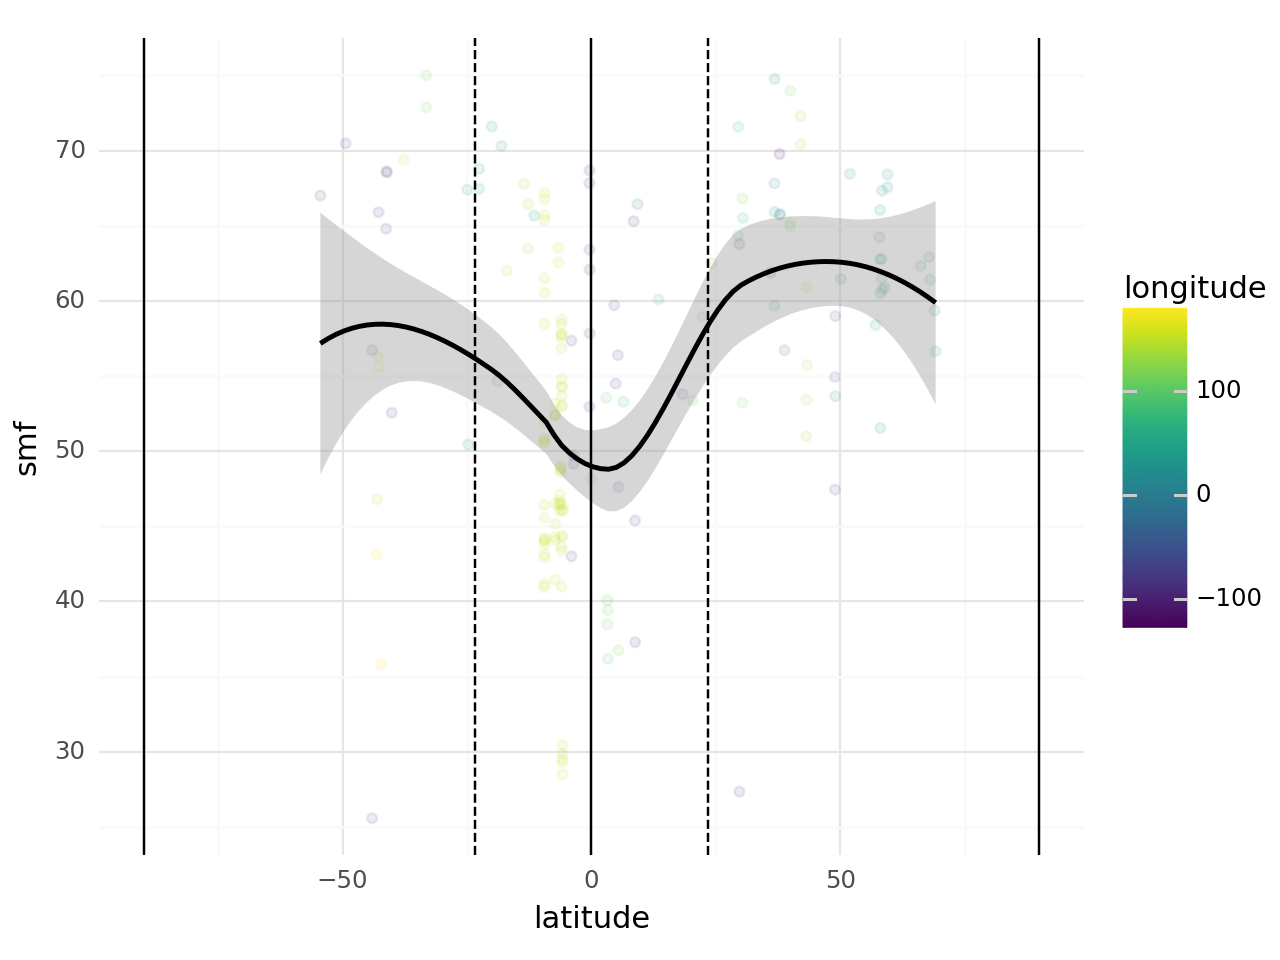

<Figure Size: (640 x 480)>

In [121]:
ggplot(sll.filter(pl.col('bioproject')=='PRJEB18701'))+geom_point(aes(x='latitude', y='smf', colour='longitude'), alpha=0.1)+geom_smooth(aes(x='latitude', y='smf'), method='loess')+theme_minimal()+geom_vline(xintercept=[0, -90, 90])+geom_vline(xintercept=[-tropic,tropic], linetype='dashed')

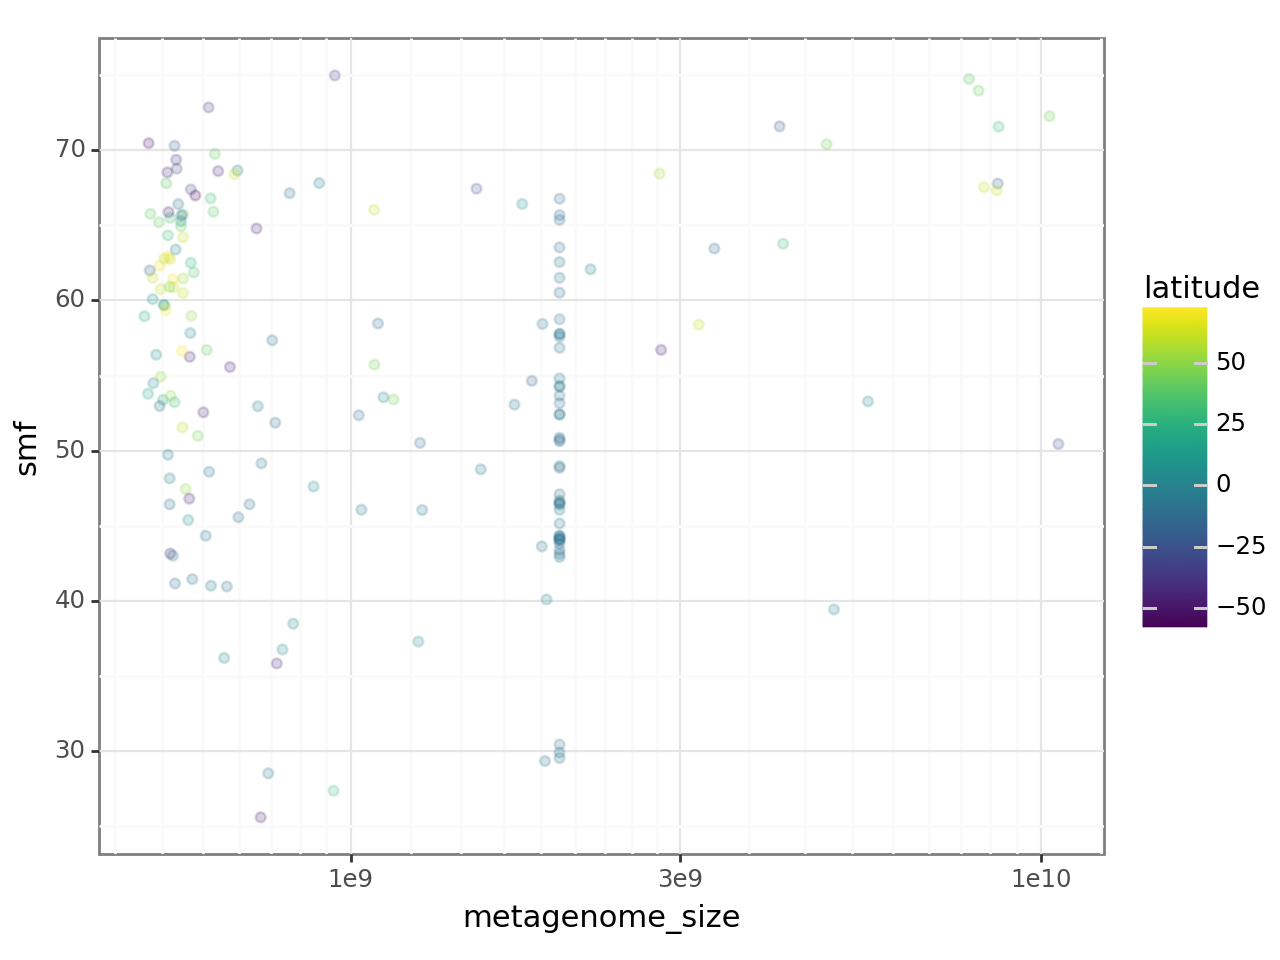

<Figure Size: (640 x 480)>

In [122]:
# That looks convincing. They aren't the most deeply sequenced though - is that the problem?
ggplot(sll.filter(pl.col('bioproject')=='PRJEB18701'))+geom_point(aes(x='metagenome_size', y='smf', colour='latitude'), alpha=0.2)+scale_x_log10()

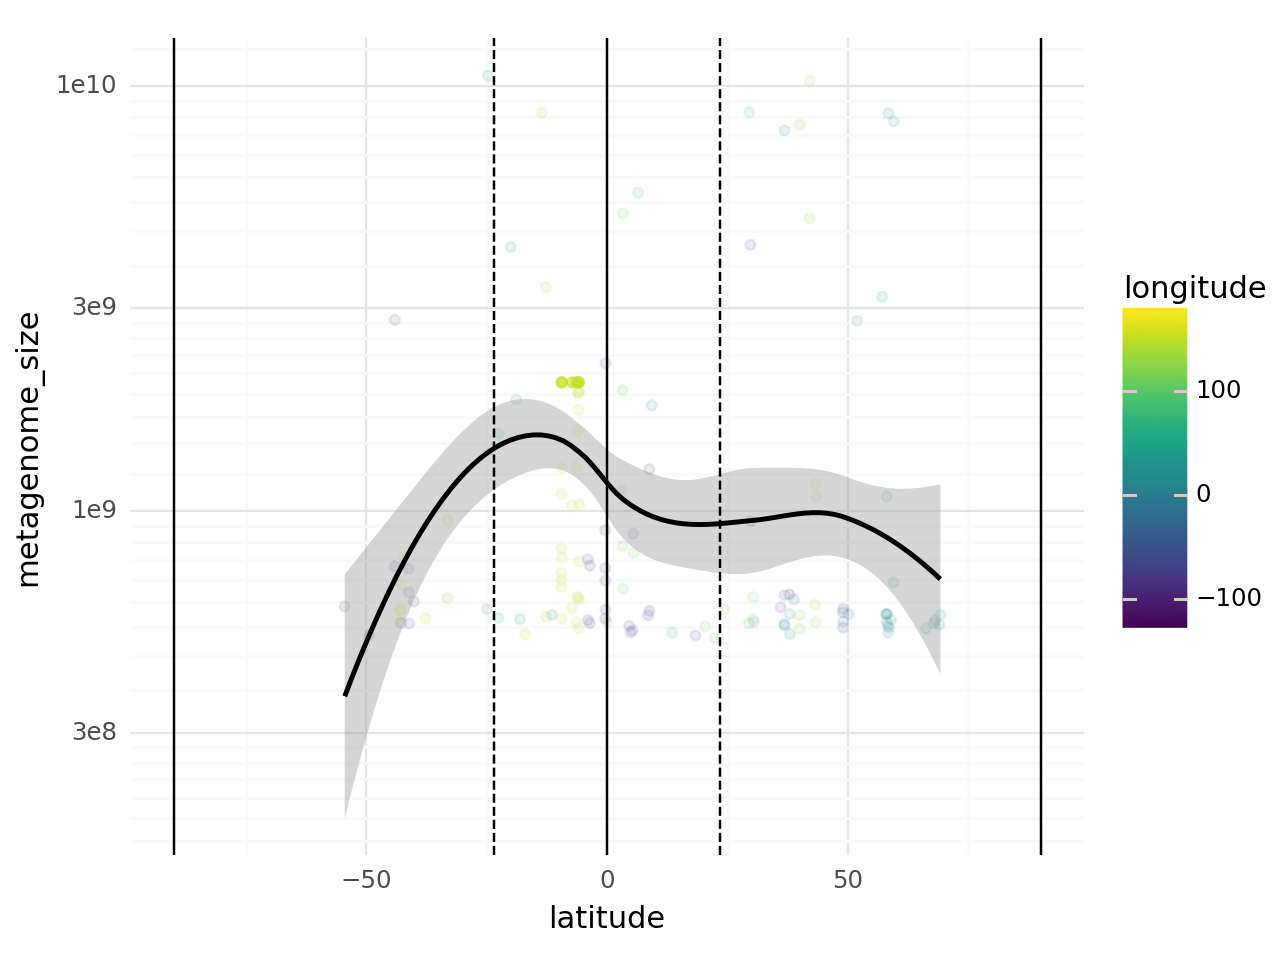

<Figure Size: (640 x 480)>

In [123]:
ggplot(sll.filter(pl.col('bioproject')=='PRJEB18701'))+geom_point(aes(x='latitude', y='metagenome_size', colour='longitude'), alpha=0.1)+geom_smooth(aes(x='latitude', y='metagenome_size'), method='loess')+theme_minimal()+geom_vline(xintercept=[0, -90, 90])+geom_vline(xintercept=[-tropic,tropic], linetype='dashed')+scale_y_log10()

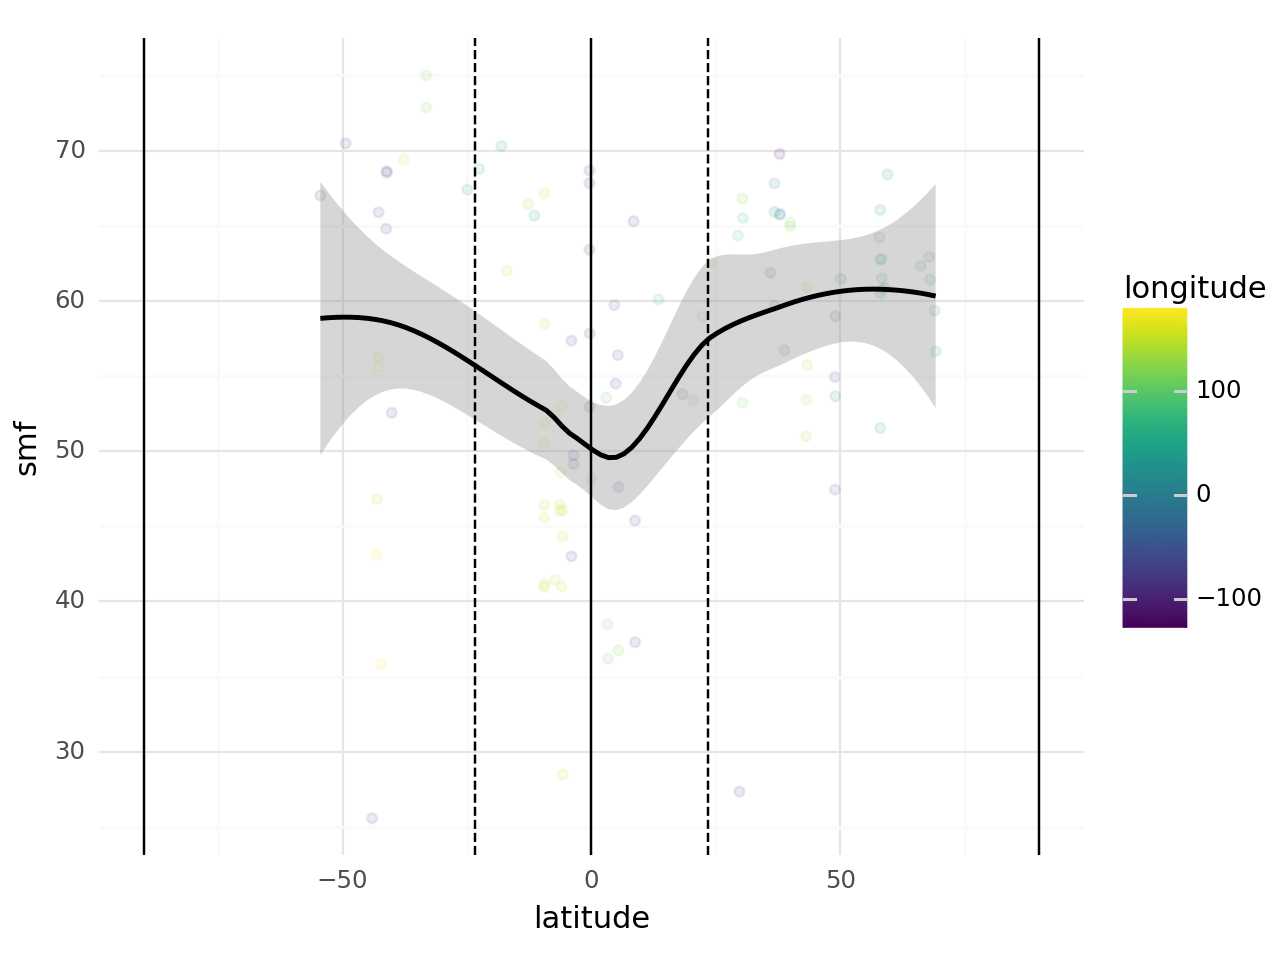

<Figure Size: (640 x 480)>

In [124]:
ggplot(sll.filter(pl.col('bioproject')=='PRJEB18701').filter(pl.col('metagenome_size')<1.5e9))+geom_point(aes(x='latitude', y='smf', colour='longitude'), alpha=0.1)+geom_smooth(aes(x='latitude', y='smf'), method='loess')+theme_minimal()+geom_vline(xintercept=[0, -90, 90])+geom_vline(xintercept=[-tropic,tropic], linetype='dashed')

In [125]:
# pvalue
ttest_ind(
    sll.filter(pl.col('bioproject')=='PRJEB18701').filter(pl.col('latitude').abs() < tropic).select(pl.col('smf')).to_pandas(),
    sll.filter(pl.col('bioproject')=='PRJEB18701').filter(pl.col('latitude').abs() > tropic).select(pl.col('smf')).to_pandas())

TtestResult(statistic=array([-6.05068907]), pvalue=array([8.60808462e-09]), df=array([174.]))

## Other bioprojects with samples inside and outside tropics, and many samples?

In [126]:
# Group by bioprojects, giving the number of tropical and non-tropical samples
sll = sll.with_columns((pl.col('latitude') < tropic).alias('tropical'))
tropical_counts = sll.filter(pl.col('tropical')==True).group_by('bioproject').len().filter(pl.col('len')>0)
non_tropical_counts = sll.filter(pl.col('tropical')==False).group_by('bioproject').len().filter(pl.col('len')>0)
# merge
yes_and_no = tropical_counts.join(non_tropical_counts, on='bioproject', how='inner')
show_all(yes_and_no)

shape: (6, 3)
┌─────────────┬─────┬───────────┐
│ bioproject  ┆ len ┆ len_right │
│ ---         ┆ --- ┆ ---       │
│ str         ┆ u32 ┆ u32       │
╞═════════════╪═════╪═══════════╡
│ PRJNA603603 ┆ 5   ┆ 1         │
│ PRJNA554847 ┆ 94  ┆ 17        │
│ PRJNA554750 ┆ 3   ┆ 40        │
│ PRJNA385547 ┆ 3   ┆ 13        │
│ PRJEB18701  ┆ 126 ┆ 50        │
│ PRJNA647683 ┆ 13  ┆ 2         │
└─────────────┴─────┴───────────┘


In [127]:
tropical_counts2 = tropical_counts.join(sll, on='bioproject', how='inner').filter(pl.col('tropical')==True).group_by('bioproject').agg(pl.col('smf').mean())
non_tropical_counts2 = non_tropical_counts.join(sll, on='bioproject', how='inner').filter(pl.col('tropical')==False).group_by('bioproject').agg(pl.col('smf').mean())
# merge
yes_and_no2 = tropical_counts2.join(non_tropical_counts2, on='bioproject', how='inner')
yes_and_no2.columns = ['bioproject', 'tropical_mean', 'non_tropical_mean']
yes_and_no2 = yes_and_no2.join(yes_and_no, on='bioproject', how='inner')
show_all(yes_and_no2)

shape: (6, 5)
┌─────────────┬───────────────┬───────────────────┬─────┬───────────┐
│ bioproject  ┆ tropical_mean ┆ non_tropical_mean ┆ len ┆ len_right │
│ ---         ┆ ---           ┆ ---               ┆ --- ┆ ---       │
│ str         ┆ f64           ┆ f64               ┆ u32 ┆ u32       │
╞═════════════╪═══════════════╪═══════════════════╪═════╪═══════════╡
│ PRJNA603603 ┆ 72.782        ┆ 77.67             ┆ 5   ┆ 1         │
│ PRJNA554847 ┆ 24.195638     ┆ 62.660588         ┆ 94  ┆ 17        │
│ PRJNA554750 ┆ 75.813333     ┆ 78.01             ┆ 3   ┆ 40        │
│ PRJNA385547 ┆ 76.953333     ┆ 75.649231         ┆ 3   ┆ 13        │
│ PRJEB18701  ┆ 52.720238     ┆ 61.8234           ┆ 126 ┆ 50        │
│ PRJNA647683 ┆ 77.815385     ┆ 81.48             ┆ 13  ┆ 2         │
└─────────────┴───────────────┴───────────────────┴─────┴───────────┘


In [128]:
# Consider just ones that have at least 5 samples in each group
show_all(yes_and_no2.filter((pl.col('len')>4) & (pl.col('len_right')>4)))

shape: (2, 5)
┌─────────────┬───────────────┬───────────────────┬─────┬───────────┐
│ bioproject  ┆ tropical_mean ┆ non_tropical_mean ┆ len ┆ len_right │
│ ---         ┆ ---           ┆ ---               ┆ --- ┆ ---       │
│ str         ┆ f64           ┆ f64               ┆ u32 ┆ u32       │
╞═════════════╪═══════════════╪═══════════════════╪═════╪═══════════╡
│ PRJNA554847 ┆ 24.195638     ┆ 62.660588         ┆ 94  ┆ 17        │
│ PRJEB18701  ┆ 52.720238     ┆ 61.8234           ┆ 126 ┆ 50        │
└─────────────┴───────────────┴───────────────────┴─────┴───────────┘


In [129]:
# So 
# │ PRJNA554847 ┆ 24.236947     ┆ 62.660588         ┆ 95  ┆ 17        │ yes  Fierer analysis of protists
# │ PRJEB42019  ┆ 77.664167     ┆ 71.959773         ┆ 36  ┆ 132       │ no   EMP500 - some strange like mouse decomposition
# │ PRJNA475650 ┆ 65.851429     ┆ 65.606842         ┆ 7   ┆ 38        │ -    eastern Chinese forests
# │ PRJNA317932 ┆ 73.304143     ┆ 76.134295         ┆ 70  ┆ 468       │ yes  Australia (BASE project)
# │ PRJNA488683 ┆ 72.773333     ┆ 76.4225           ┆ 12  ┆ 12        │ yes  southern Chinese, rice-associated
# │ PRJNA595820 ┆ 77.028889     ┆ 71.223333         ┆ 9   ┆ 6         │ no   rhizosphere
# │ PRJEB18701  ┆ 52.720946     ┆ 61.43763          ┆ 148 ┆ 135       │ yes  global topsoil microbiome

In [171]:
# For the EMP500, is there a difference in the sample types?
emp500 = sll.filter(pl.col('bioproject')=='PRJEB42019')
emp500.select(['acc','smf','latitude','longitude','tropical'])

acc,smf,latitude,longitude,tropical
str,f64,f64,f64,bool


In [131]:
# emp500_accessions = set(emp500.select('acc')['acc'])

# kingfisher_emp500 = kingfisher.filter(pl.col('run').is_in(emp500_accessions))

In [132]:
# emp500 = emp500.join(kingfisher, left_on='acc', right_on='run', how='inner')

In [133]:
# show_all(emp500.select('acc','library_name','smf'))

# STAT estimates

In [134]:
stat_estimates = pl.read_csv('../../data/sra/NCBI_method_taxonomy_processed.csv.gz', null_values=['NA','null'])
stat_estimates.shape, stat_estimates[:3]

((370579, 14),
 shape: (3, 14)
 ┌───────────┬─────────┬──────────┬───────────┬───┬────────────┬────────────┬───────────┬───────────┐
 │ acc       ┆ Archaea ┆ Bacteria ┆ Eukaryota ┆ … ┆ microbial_ ┆ human_frac ┆ viral_fra ┆ euks_frac │
 │ ---       ┆ ---     ┆ ---      ┆ ---       ┆   ┆ fraction   ┆ tion       ┆ ction     ┆ tion      │
 │ str       ┆ i64     ┆ i64      ┆ i64       ┆   ┆ ---        ┆ ---        ┆ ---       ┆ ---       │
 │           ┆         ┆          ┆           ┆   ┆ f64        ┆ f64        ┆ f64       ┆ f64       │
 ╞═══════════╪═════════╪══════════╪═══════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
 │ DRR000713 ┆ 0       ┆ 2561     ┆ 1263869   ┆ … ┆ 0.000163   ┆ 0.000009   ┆ 0.000002  ┆ 0.080662  │
 │ DRR000714 ┆ 0       ┆ 3578     ┆ 1888392   ┆ … ┆ 0.000249   ┆ 0.0        ┆ 6.2730e-7 ┆ 0.131621  │
 │ DRR001356 ┆ 6       ┆ 193788   ┆ 35841     ┆ … ┆ 0.124108   ┆ 0.002975   ┆ 0.00051   ┆ 0.022953  │
 └───────────┴─────────┴──────────┴───────────┴───┴

In [135]:
stat_smf = stat_estimates.join(m, left_on='acc', right_on='acc', how='inner').filter(pl.col('organism')=='soil metagenome')
stat_smf.shape, stat_smf[:3]

((4655, 29),
 shape: (3, 29)
 ┌───────────┬─────────┬──────────┬───────────┬───┬────────────┬────────────┬───────────┬───────────┐
 │ acc       ┆ Archaea ┆ Bacteria ┆ Eukaryota ┆ … ┆ library_se ┆ model      ┆ sample_na ┆ taxon_nam │
 │ ---       ┆ ---     ┆ ---      ┆ ---       ┆   ┆ lection    ┆ ---        ┆ me        ┆ e         │
 │ str       ┆ i64     ┆ i64      ┆ i64       ┆   ┆ ---        ┆ str        ┆ ---       ┆ ---       │
 │           ┆         ┆          ┆           ┆   ┆ str        ┆            ┆ str       ┆ str       │
 ╞═══════════╪═════════╪══════════╪═══════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
 │ DRR001455 ┆ 62      ┆ 164542   ┆ 2731      ┆ … ┆ RANDOM     ┆ Illumina   ┆ Polluted  ┆ soil meta │
 │           ┆         ┆          ┆           ┆   ┆            ┆ Genome     ┆ soil      ┆ genome    │
 │           ┆         ┆          ┆           ┆   ┆            ┆ Analyzer   ┆ sample 0  ┆           │
 │           ┆         ┆          ┆           ┆   ┆  

In [136]:
[
    stat_smf.filter(pl.col('smf') > 50).shape[0] / len(stat_smf),
    stat_smf.filter(pl.col('Archaea')+pl.col('Bacteria') < 0.5 * pl.col('analyzed_spot_count')).shape[0] / len(stat_smf),
stat_smf.filter(pl.col('Archaea')+pl.col('Bacteria') < 0.1 * pl.col('analyzed_spot_count')).shape[0] / len(stat_smf)
]

[0.8878625134264232, 0.8618689581095597, 0.679484425349087]

# Overall amount of microbial fraction

In [137]:
soils.select(pl.median('smf').alias('median'), pl.mean('smf').alias('mean'), pl.std('smf').alias('sd'), pl.quantile('smf', 0.25).alias('perc25'), pl.quantile('smf', 0.75).alias('perc75'), pl.min('smf').alias('min'), pl.max('smf').alias('max'))

median,mean,sd,perc25,perc75,min,max
f64,f64,f64,f64,f64,f64,f64
68.17,65.980881,16.664713,61.06,76.59,0.01,100.0


# Write out data for supplementary

In [138]:
sll = sll.with_columns(pl.col('smf').map_elements(lambda x: bacterial_to_fungi_cell_relabund(bacterial_genome_size_estimate, fungal_genome_size_estimate, x/100)).list.get(1).alias('Fungi to Bacteria Ratio'))
# sll.write_csv('soil_data_for_supplementary.csv')

# What is the average genome size in a soil metagenome?

In [139]:
sll.select(pl.col('average_bacterial_archaeal_genome_size').mean())

average_bacterial_archaeal_genome_size
f64
4.4565e6


In [140]:
# GTDB average of bacteria is 3266043.5. So soil bacteria are 4.456/3.266 = 1.36 times larger than average.
#4.456/3.266 => 1.36

# So if genome size is the entire cause of soils having low microbial_fraction (69%) is 100/69*4.456 = 6.47

# What is the average genome size of a soil isolate?

In [141]:
isolation_sources = pl.read_csv('../../data/isolation_sources_bacdive_2024-07-18.csv')
isolation_sources[:3]

ID,Species,Culture collection number,Isolation source,Country,Continent,Category 1,Category 2,Category 3
i64,str,str,str,str,str,str,str,str
159652,"""Abditibacteriu…","""DSM 105287, LM…","""Top surface sa…","""Antarctica""","""Australia and …","""#Environmental…","""#Terrestrial""","""#Geologic"""
159652,null,null,null,null,null,"""#Climate""","""#Cold""","""#Alpine"""
219,"""Abiotrophia de…","""DSM 9849, ATCC…","""Human, Blood##…","""France""","""Europe""","""#Host Body Pro…","""#Fluids""","""#Blood"""


In [142]:
iso_id_species = isolation_sources.filter(pl.col('Species').is_not_null()).select('ID', 'Species')
iso_soil_ids = isolation_sources.filter(pl.col('Category 3').str.contains('#Soil')).select('ID','Category 3')
iso_id_species[:3], iso_soil_ids[:3]

(shape: (3, 2)
 ┌────────┬─────────────────────────────┐
 │ ID     ┆ Species                     │
 │ ---    ┆ ---                         │
 │ i64    ┆ str                         │
 ╞════════╪═════════════════════════════╡
 │ 159652 ┆ Abditibacterium utsteinense │
 │ 219    ┆ Abiotrophia defectiva       │
 │ 144952 ┆ Abiotrophia defectiva       │
 └────────┴─────────────────────────────┘,
 shape: (3, 2)
 ┌───────┬────────────┐
 │ ID    ┆ Category 3 │
 │ ---   ┆ ---        │
 │ i64   ┆ str        │
 ╞═══════╪════════════╡
 │ 22965 ┆ #Soil      │
 │ 9     ┆ #Soil      │
 │ 9     ┆ #Soil      │
 └───────┴────────────┘)

In [143]:
iso_soil = iso_soil_ids.group_by('ID').first().join(iso_id_species, on='ID', how='inner').group_by('Species').first()
iso_soil_ids.shape, iso_soil.shape, iso_soil[:3]

((14451, 2),
 (3598, 3),
 shape: (3, 3)
 ┌────────────────────────┬────────┬────────────┐
 │ Species                ┆ ID     ┆ Category 3 │
 │ ---                    ┆ ---    ┆ ---        │
 │ str                    ┆ i64    ┆ str        │
 ╞════════════════════════╪════════╪════════════╡
 │ Archangium sp.         ┆ 8633   ┆ #Soil      │
 │ Kribbella sandramycini ┆ 11070  ┆ #Soil      │
 │ Klebsiella terrigena   ┆ 147343 ┆ #Soil      │
 └────────────────────────┴────────┴────────────┘)

In [144]:
iso_soil[:3]

Species,ID,Category 3
str,i64,str
"""Archangium sp.…",8633,"""#Soil"""
"""Kribbella sand…",11070,"""#Soil"""
"""Klebsiella ter…",147343,"""#Soil"""


In [145]:
# Retrieve one
import requests
from requests.auth import HTTPBasicAuth
import bacdive
from private_credentials import USERNAME, PASSWORD
client = bacdive.BacdiveClient(USERNAME, PASSWORD)


-- Authentication successful --


In [146]:
# # Takes about at hour to run this, so we have cached the results
# # # Get the NCBI taxon IDs for each, so these can be linked to GTDB via the metadata. For now, just get everything.
# import tqdm
# id_to_bacdive = {}
# for bacdive_id in tqdm.tqdm(iso_soil['ID']):
#     # print(bacdive_id)
#     count = client.search(**{'id': bacdive_id})
#     if count < 1:
#         print("No results for {}".format(bacdive_id))
#         continue
#     data = list(client.retrieve())
#     id_to_bacdive[bacdive_id] = data
#     # break

In [147]:
# import json
# with open('../../data/bacdive_isolation_sources.json', 'w') as f:
#     json.dump(id_to_bacdive, f)

In [148]:
import json
with open('../../data/bacdive_isolation_sources.json') as f:
    id_to_bacdive2 = json.load(f)

In [149]:
id_to_bacdive2[list(id_to_bacdive2.keys())[0]]

[{'General': {'@ref': 64712,
   'BacDive-ID': 158133,
   'DSM-Number': 106081,
   'keywords': ['genome sequence', 'Bacteria'],
   'description': 'Novosphingobium sp. ST904 is a bacterium that was isolated from soil.',
   'NCBI tax id': {'NCBI tax id': 1874826, 'Matching level': 'species'},
   'strain history': {'@ref': 64712,
    'history': '<- S. Thijs, Hasselt University, Diepenbeek, Belgium; ST904'},
   'doi': '10.13145/bacdive158133.20240510.9'},
  'Name and taxonomic classification': {'LPSN': {'@ref': 20215,
    'description': 'domain/bacteria',
    'keyword': 'phylum/pseudomonadota',
    'domain': 'Bacteria',
    'phylum': 'Pseudomonadota',
    'class': 'Alphaproteobacteria',
    'order': 'Sphingomonadales',
    'family': 'Erythrobacteraceae',
    'genus': 'Novosphingobium',
    'species': 'Novosphingobium sp.',
    'full scientific name': '<I>Novosphingobium</I> Takeuchi et al. 2001'},
   '@ref': 64712,
   'domain': 'Bacteria',
   'phylum': 'Proteobacteria',
   'class': 'Alphapr

In [150]:
# Read gtdb bacteria taxonomy
gtdb = pl.read_csv('~/m/db/gtdb/gtdb_release214/bac120_metadata_r214.tsv', separator='\t')

In [151]:
# Get taxon IDs of the json
taxon_ids = set()
num_good = 0
num_fail = 0
for bacdive_id, data in id_to_bacdive2.items():
    if len(data) > 1:
        raise Exception("Multiple results for {}".format(bacdive_id))
    d = data[0]['General']
    if 'NCBI tax id' not in d:
        num_fail += 1
        continue
    tax_id1 = d['NCBI tax id']
    if 'NCBI tax id' not in tax_id1:
        num_fail += 1
        continue
    tax_id = tax_id1['NCBI tax id']
    taxon_ids.add(tax_id)
    num_good += 1
print(f'Found {len(taxon_ids)} unique taxon IDs, {num_good} good, {num_fail} failed')

Found 3127 unique taxon IDs, 3148 good, 450 failed


In [152]:
# Merge the taxids with GTDB
gtdb_soil = gtdb.filter(pl.col('ncbi_species_taxid').is_in(taxon_ids)).filter(pl.col('gtdb_representative')=='t')
gtdb_soil.shape

(4005, 110)

In [153]:
gtdb_soil.group_by('ncbi_species_taxid').first().select(pl.col('genome_size').mean())

genome_size
f64
5.9887e6


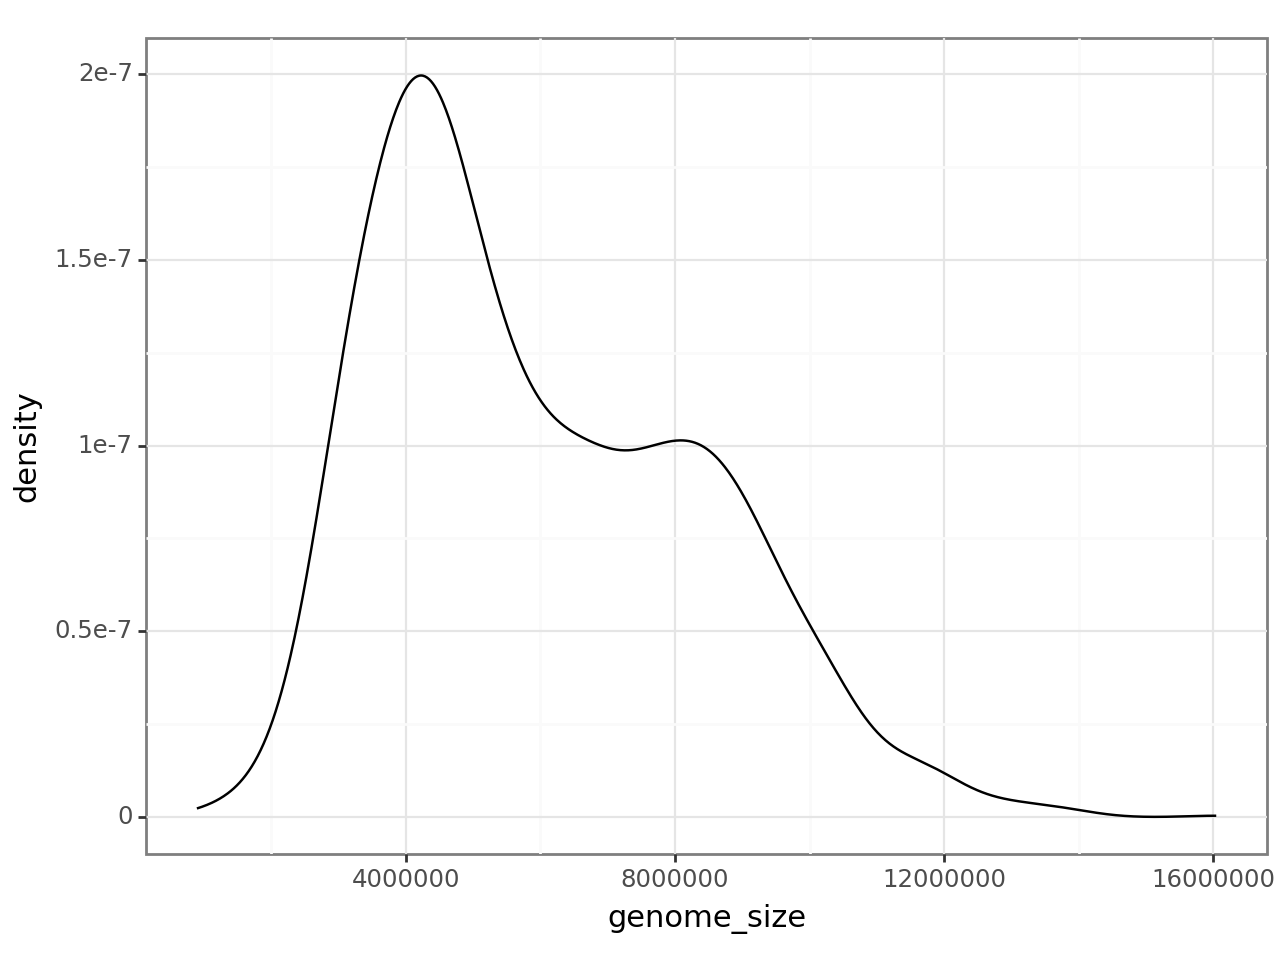

<Figure Size: (640 x 480)>

In [154]:
soil_firsts = gtdb_soil.group_by('ncbi_species_taxid').first()
soil_firsts = soil_firsts.with_columns(pl.col('gtdb_taxonomy').str.contains('p__Pseudomonadota').alias('p__Pseudomonadota'))
# Actinobacteriota
soil_firsts = soil_firsts.with_columns(pl.col('gtdb_taxonomy').str.contains('p__Actinomycetota').alias('p__Actinomycetota'))
# soil_firsts.group_by('p__Actinomycetota').len()
# Select 10 at random
# show_all(soil_firsts.select('gtdb_taxonomy').sample(10))
# soil_firsts.select('genome_size').head()
ggplot(soil_firsts.to_pandas())+geom_density(aes('genome_size'))

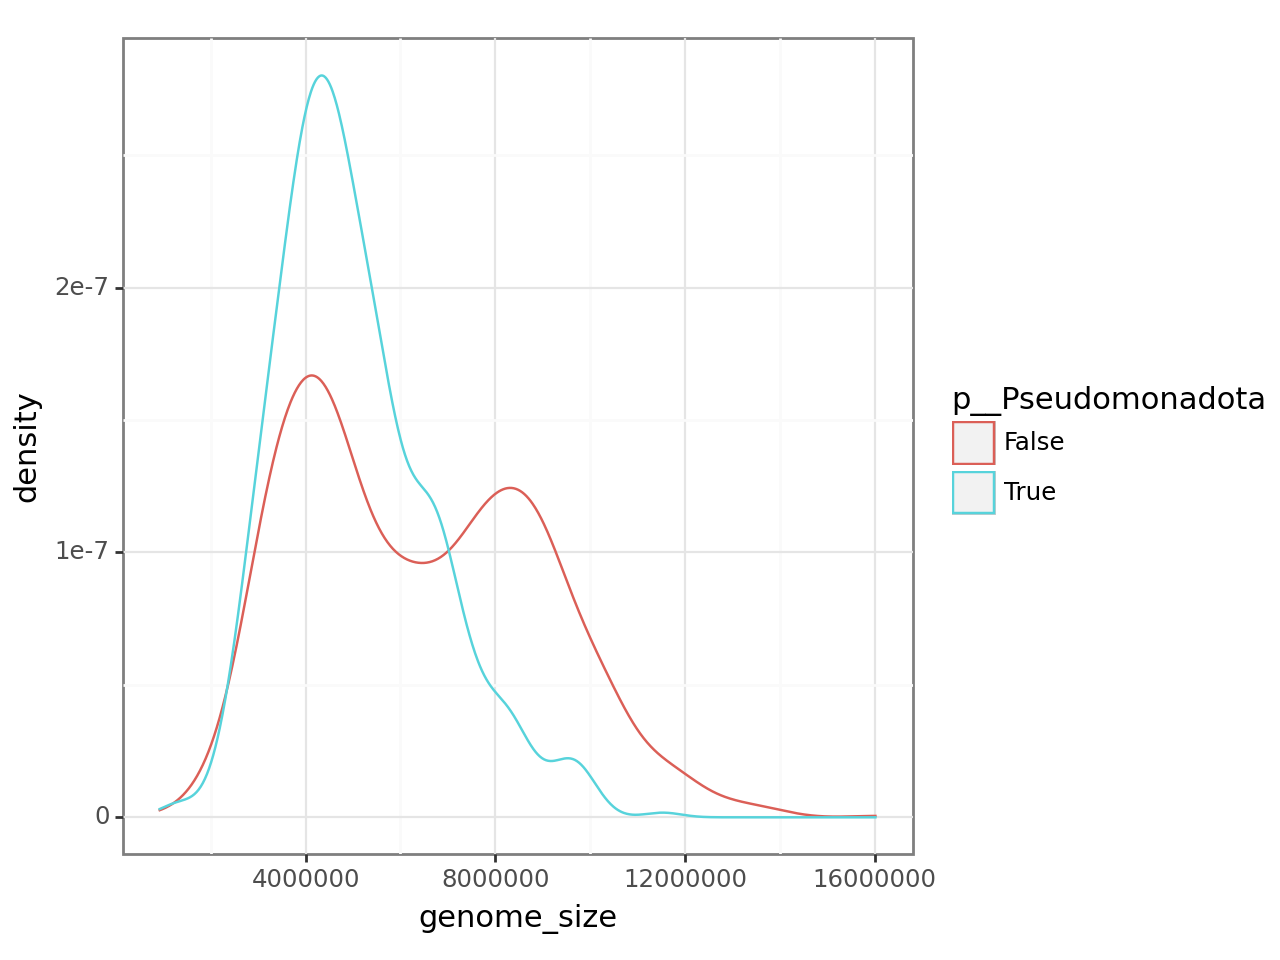

<Figure Size: (640 x 480)>

In [155]:
ggplot(soil_firsts.to_pandas())+geom_density(aes('genome_size', color='p__Pseudomonadota'))

/home/woodcrob/e/mybase/lib/python3.11/site-packages/plotnine/scales/scale_size.py:49: PlotnineWarning: Using size for a discrete variable is not advised.


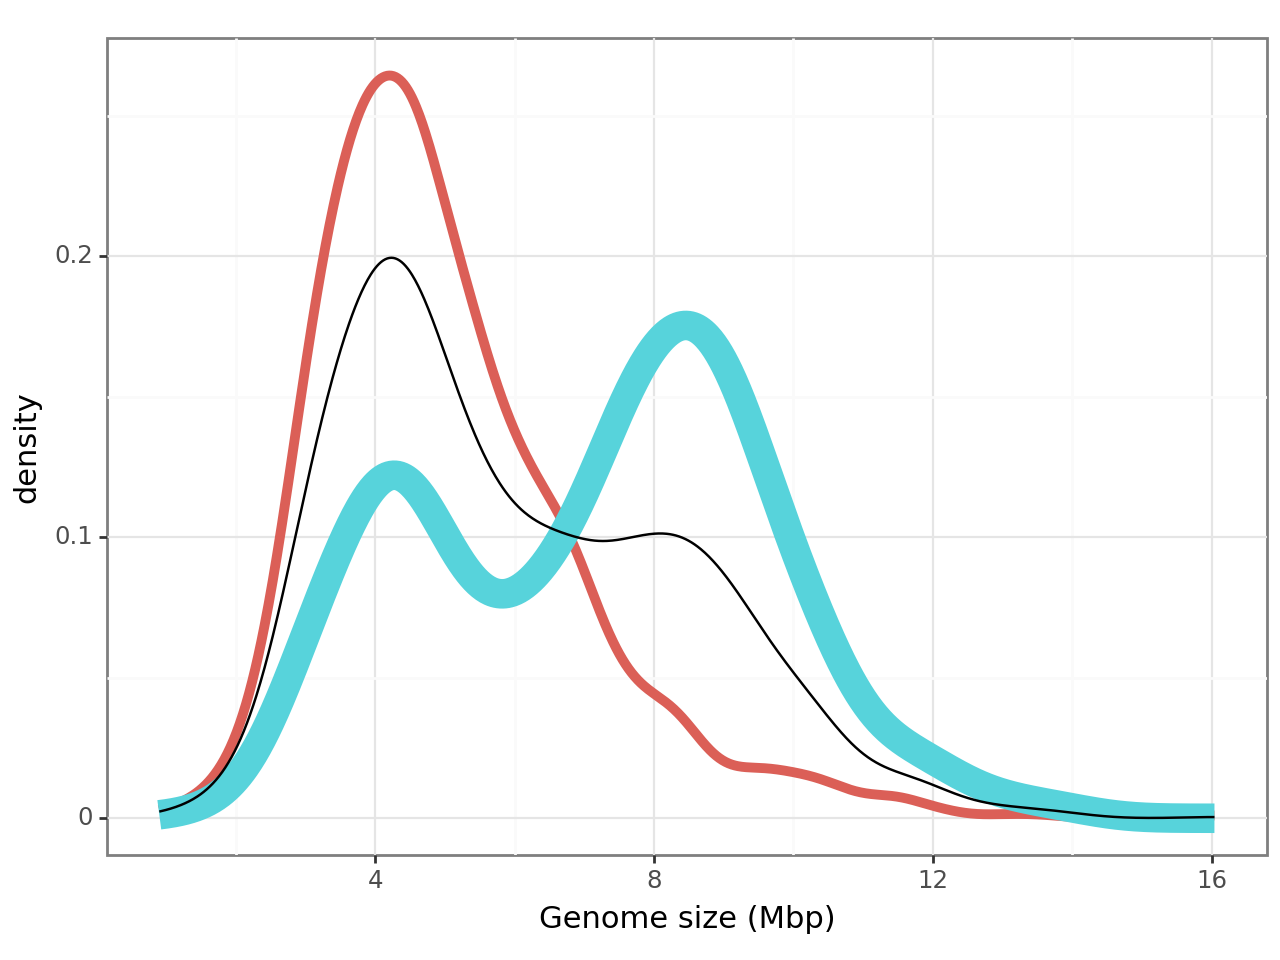

<Figure Size: (640 x 480)>

In [196]:
p = ggplot(soil_firsts.with_columns(pl.col('genome_size')/1e6)) + \
    geom_density(aes(x='genome_size', color='p__Actinomycetota', size='p__Actinomycetota')) + \
    geom_density(aes(x='genome_size')) + \
    labs(x='Genome size (Mbp)') + \
    theme(legend_position='none')
# p.save('soil_genome_size_density.svg', width=6, height=4, dpi=200)
p

In [193]:
(
    soil_firsts.select([
        pl.col('genome_size').mean().alias('mean'),
        pl.col('genome_size').std().alias('std')
    ]),    
    soil_firsts.filter(pl.col('p__Actinomycetota')).select([
        pl.col('genome_size').mean().alias('mean'),
        pl.col('genome_size').std().alias('std')
    ]),
    soil_firsts.filter(~pl.col('p__Actinomycetota')).select([
        pl.col('genome_size').mean().alias('mean'),
        pl.col('genome_size').std().alias('std')
    ])
)

(shape: (1, 2)
 ┌──────────┬──────────┐
 │ mean     ┆ std      │
 │ ---      ┆ ---      │
 │ f64      ┆ f64      │
 ╞══════════╪══════════╡
 │ 5.9887e6 ┆ 2.4055e6 │
 └──────────┴──────────┘,
 shape: (1, 2)
 ┌──────────┬──────────┐
 │ mean     ┆ std      │
 │ ---      ┆ ---      │
 │ f64      ┆ f64      │
 ╞══════════╪══════════╡
 │ 7.1573e6 ┆ 2.4650e6 │
 └──────────┴──────────┘,
 shape: (1, 2)
 ┌──────────┬──────────┐
 │ mean     ┆ std      │
 │ ---      ┆ ---      │
 │ f64      ┆ f64      │
 ╞══════════╪══════════╡
 │ 5.0378e6 ┆ 1.8812e6 │
 └──────────┴──────────┘)

In [158]:
soil_firsts = soil_firsts.with_columns(pl.col('gtdb_taxonomy').str.split(';').list.get(2).alias('class'))
soil_firsts.select('class').group_by('class').len().sort('len', descending=True).head(10)

class,len
str,u32
"""c__Actinomycet…",882
"""c__Gammaproteo…",381
"""c__Bacilli""",219
"""c__Alphaproteo…",201
"""c__Bacteroidia…",153
"""c__Clostridia""",34
"""c__Myxococcia""",21
"""c__Terriglobia…",15
"""c__Deinococci""",13


In [159]:
soil_firsts.filter(pl.col('p__Actinomycetota')).select('class','genome_size').group_by('class').len()

class,len
str,u32
"""c__Thermoleoph…",2
"""c__Acidimicrob…",3
"""c__Actinomycet…",882


In [160]:
# Write out taxonomy tab sep

# soil_firsts.select(pl.col('gtdb_taxonomy').str.split(';').list.join('\t').str.replace(r'^','1\t')).write_csv('soil_isolates_gtdb_taxonomy.tsv', include_header=False)

# $ ktImportText -o soil_isolates_gtdb_taxonomy.html soil_isolates_gtdb_taxonomy.tsv
# Writing soil_isolates_gtdb_taxonomy.html...

In [190]:
g = soil_firsts.group_by('p__Actinomycetota').len()
print(g)
actino_len = g.filter(pl.col('p__Actinomycetota')==True)[0,1]
non_actino_len = g.filter(pl.col('p__Actinomycetota')==False)[0,1]
print(actino_len, non_actino_len, actino_len / (actino_len+non_actino_len))

shape: (2, 2)
┌───────────────────┬──────┐
│ p__Actinomycetota ┆ len  │
│ ---               ┆ ---  │
│ bool              ┆ u32  │
╞═══════════════════╪══════╡
│ false             ┆ 1090 │
│ true              ┆ 887  │
└───────────────────┴──────┘
887 1090 0.4486595852301467


# Does average genome size increase with higher known species fraction?

In [161]:
# Read known species fraction - waiting for pipeline to finish
per_acc_summary = pl.read_csv('../../data/sra/sandpiper_0.2.0_per_acc_summary.csv')
per_acc_summary[:3]

sample,root_coverage,species_coverage,bacterial_archaeal_bases,metagenome_size,read_fraction,average_bacterial_archaeal_genome_size,warning,prediction,organism,host_or_not
str,f64,f64,i64,f64,f64,i64,str,str,str,str
"""SRR8634435""",344.67,0.935533,1178735067,1.2550e9,93.92,3419895,null,"""host""","""feces metageno…","""host"""
"""SRR8640623""",730.53,0.123335,1418304662,3.2740e9,43.32,1941474,null,"""ecological""","""wastewater met…","""ecological"""
"""SRR8692214""",2257.27,0.973601,7567256125,7.7290e9,97.91,3352393,null,"""host""","""human gut meta…","""host"""


In [162]:
# Merge with the soil data
per_acc_summary_soil = per_acc_summary.filter(pl.col('sample').is_in(sll['acc']))
per_acc_summary_soil.shape

(3960, 11)

In [163]:
per_acc_summary_soil = per_acc_summary_soil.with_columns(pl.col('species_coverage').alias('known_species_fraction')/pl.col('root_coverage')*100)
per_acc_summary_soil[:3]

sample,root_coverage,species_coverage,bacterial_archaeal_bases,metagenome_size,read_fraction,average_bacterial_archaeal_genome_size,warning,prediction,organism,host_or_not,known_species_fraction
str,f64,f64,i64,f64,f64,i64,str,str,str,str,f64
"""ERR2239870""",150.64,0.0,636233701,9.42e8,67.54,4223538,null,"""ecological""","""soil metagenom…","""ecological""",0.0
"""ERR2233332""",321.58,0.002581,1526444587,2.2930e9,66.57,4746702,null,"""ecological""","""soil metagenom…","""ecological""",0.000803
"""ERR2239869""",145.17,0.0,631314570,9.71e8,65.02,4348795,null,"""ecological""","""soil metagenom…","""ecological""",0.0


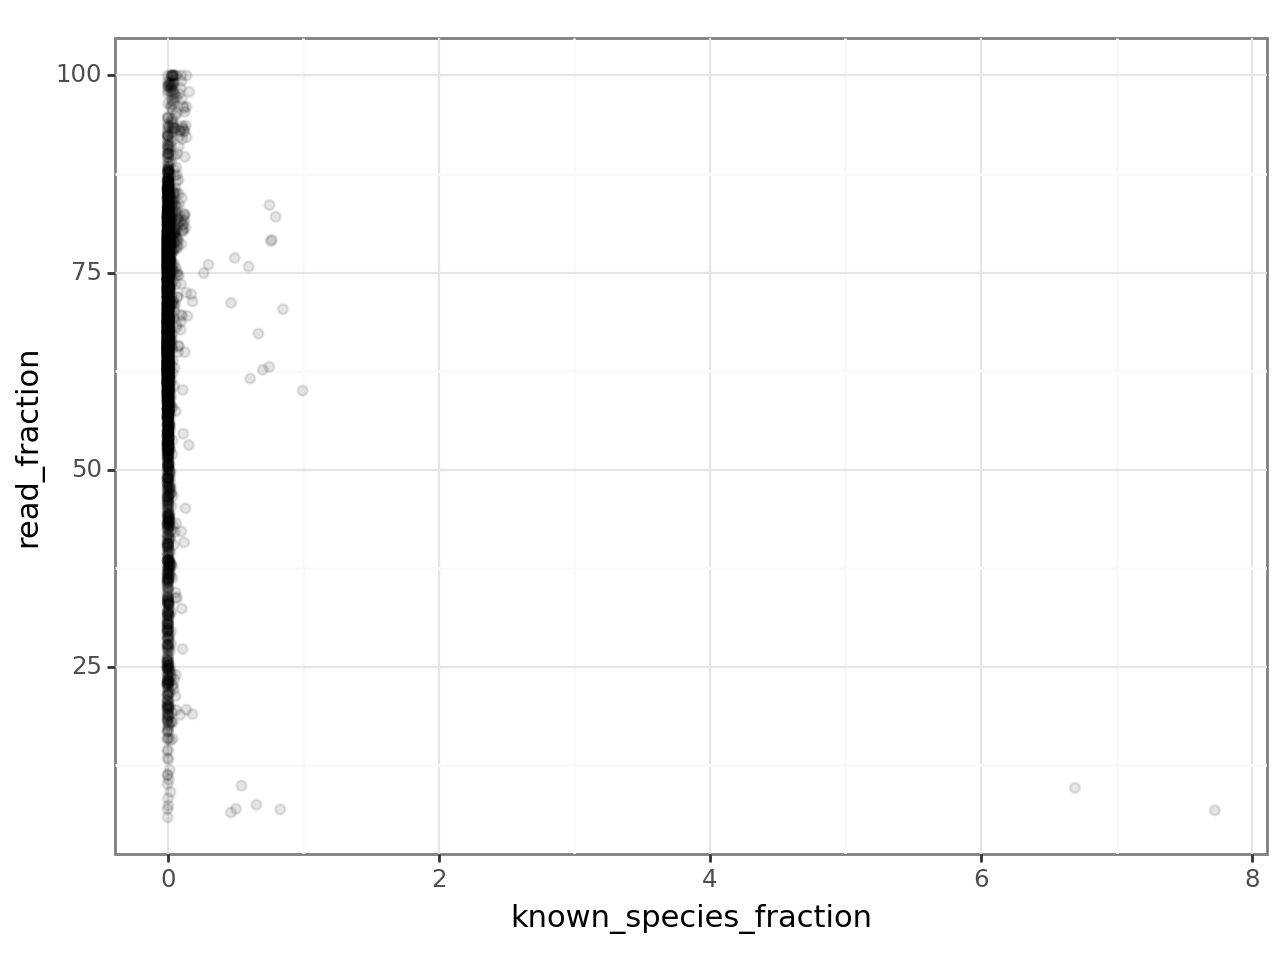

<Figure Size: (640 x 480)>

In [164]:
ggplot(per_acc_summary_soil.to_pandas())+geom_point(aes(x='known_species_fraction', y='read_fraction'), alpha=0.1)

# How much of a soil metagenome is not classified to the phylum level?

In [165]:
# sll
classification_rates = pl.read_csv('../../data/sra/sandpiper_0.2.0_taxonomic_level_coverage.csv.gz', separator='\t')
classification_rates[:3]

sample,level,coverage,relative abundance (%)
str,str,f64,f64
"""SRR8634435""","""domain""",1.46,0.42
"""SRR8634435""","""phylum""",0.12,0.03
"""SRR8634435""","""class""",5.89,1.71


In [166]:
soil_classification_rates = classification_rates.filter(pl.col('sample').is_in(sll['acc']))
num_samples = soil_classification_rates.select(pl.col('sample').unique().len())[0,0]

# need to include the 0 count ones, so append enough zeroes and then call mean and std
domain_level_rates = soil_classification_rates.filter(pl.col('level')=='domain')['relative abundance (%)']
num_zeroes = num_samples - len(domain_level_rates)
domain_level_rates2 = domain_level_rates.append(pl.Series("", [0.]*num_zeroes))
num_samples, num_zeroes, domain_level_rates2.shape[0], domain_level_rates2.mean(), domain_level_rates2.std()

# classification_rates.filter(pl.col('level')=='domain').filter(pl.col('sample').is_in(sll['acc'])).select(
#     pl.mean('relative abundance (%)').alias('mean_domain_abundance'),
#     pl.std('relative abundance (%)').alias('std_domain_abundance'),
#     pl.len().alias('num_samples')
# ), classification_rates.filter(pl.col('sample').is_in(sll['acc'])).select(pl.col('sample').unique().len())

(3960, 528, 3960, 1.6456363636363638, 1.77975606432115)

# What are the low SMF soil samples?

In [167]:
sll.filter(pl.col('smf')<10).sample(5)

# SRR3984901 - fosmid clones, Not a real metagenome
# SRR16123996 - viral
# SRR8487016 - viral
# SRR15603312 - anaerobic digestion, not soil
# SRR3984956 - fosmid clones, Not a real metagenome

m.filter(pl.col('organism')=='soil metagenome').filter(pl.col('smf')<10).sample(5)


acc,bioproject,organism,bacterial_archaeal_bases,metagenome_size,read_fraction,average_bacterial_archaeal_genome_size,warning,smf,bioproject_right,Gbp,library_strategy,library_selection,model,sample_name,taxon_name
str,str,str,i64,f64,str,i64,str,f64,str,f64,str,str,str,str,str
"""SRR3984899""","""PRJNA330045""","""soil metagenom…",1309902,9.11e8,"""0.14%""",3358722,null,0.14,"""PRJNA330045""",0.912,"""WGS""","""RANDOM""","""Illumina HiSeq…","""NNNN""","""soil metagenom…"
"""SRR8487020""","""PRJNA646773""","""soil metagenom…",225842059,3.8450e9,"""5.87%""",2314193,null,5.87,"""PRJNA646773""",3.845,"""WGS""","""RANDOM""","""Illumina HiSeq…","""PineBiochar_Lo…","""soil metagenom…"
"""SRR2247250""","""PRJNA217052""","""soil metagenom…",17964895,1.2020e9,"""1.49%""",3402442,null,1.49,"""PRJNA217052""",1.203,"""WGS""","""RANDOM""","""Illumina HiSeq…","""Pond-221535""","""soil metagenom…"
"""SRR8357467""","""PRJNA509545""","""soil metagenom…",87315386,8.82e8,"""9.90%""",3870363,null,9.9,"""PRJNA509545""",0.882,"""WGS""","""RANDOM""","""Illumina MiSeq…","""L03""","""soil metagenom…"
"""SRR3984952""","""PRJNA330045""","""soil metagenom…",11241061,1.1880e9,"""0.95%""",4373954,null,0.95,"""PRJNA330045""",1.188,"""WGS""","""RANDOM""","""Illumina HiSeq…","""NGCY""","""soil metagenom…"


# How much are things classified in soils?

In [168]:
classification_levels = pl.read_csv('../../data/sra/sandpiper_0.2.0_taxonomic_level_coverage.csv.gz', separator='\t')
classification_levels[:3]

sample,level,coverage,relative abundance (%)
str,str,f64,f64
"""SRR8634435""","""domain""",1.46,0.42
"""SRR8634435""","""phylum""",0.12,0.03
"""SRR8634435""","""class""",5.89,1.71


In [169]:
# First remove anything where there is not the standard levels of classification, to get the total number of samples
level_order = ['domain','phylum','class','order','family','genus','species']
soil_classification_rates = classification_rates.filter(pl.col('level').is_in(
    level_order
)).filter(pl.col('sample').is_in(sll['acc']))
num_samples = soil_classification_rates.filter(pl.col('level').is_in(
    level_order
)).select(pl.col('sample').unique().len())[0,0]
num_samples

level_rates = soil_classification_rates.group_by('level').sum()
level_rates = level_rates.with_columns(pl.col('relative abundance (%)').alias('relative abundance (%)')/num_samples)
# print(level_rates.select('relative abundance (%)').sum())
# print(level_rates.filter(pl.col('level').is_in(['species','genus'])).sum())
# print(classification_levels.group_by('sample').len().shape[0])
print(level_rates.select(
    pl.col('level'),
    pl.col('relative abundance (%)').round(1)
).sort('relative abundance (%)'))
print(sll.shape[0])


# # need to include the 0 count ones, so append enough zeroes and then call mean and std
# domain_level_rates = soil_classification_rates.filter(pl.col('level')=='domain')['relative abundance (%)']
# num_zeroes = num_samples - len(domain_level_rates)
# domain_level_rates2 = domain_level_rates.append(pl.Series("", [0.]*num_zeroes))
# num_samples, num_zeroes, domain_level_rates2.shape[0], domain_level_rates2.mean(), domain_level_rates2.std()

# classification_rates.filter(pl.col('level')=='domain').filter(pl.col('sample').is_in(sll['acc'])).select(
#     pl.mean('relative abundance (%)').alias('mean_domain_abundance'),
#     pl.std('relative abundance (%)').alias('std_domain_abundance'),
#     pl.len().alias('num_samples')
# ), classification_rates.filter(pl.col('sample').is_in(sll['acc'])).select(pl.col('sample').unique().len())

shape: (7, 2)
┌─────────┬────────────────────────┐
│ level   ┆ relative abundance (%) │
│ ---     ┆ ---                    │
│ str     ┆ f64                    │
╞═════════╪════════════════════════╡
│ phylum  ┆ 1.9                    │
│ domain  ┆ 1.9                    │
│ class   ┆ 4.7                    │
│ order   ┆ 6.5                    │
│ species ┆ 9.9                    │
│ family  ┆ 21.2                   │
│ genus   ┆ 53.9                   │
└─────────┴────────────────────────┘
3960


# Is there a relationship between fraction of unknown lineages and SMF?

/tmp/ipykernel_1978589/3427358541.py:3: PolarsInefficientMapWarning: 
Expr.map_elements is significantly slower than the native expressions API.
Only use if you absolutely CANNOT implement your logic otherwise.
Replace this expression...
  - pl.col("level").map_elements(lambda x: ...)
with this one instead:
  + pl.col("level").replace(level_to_rank)



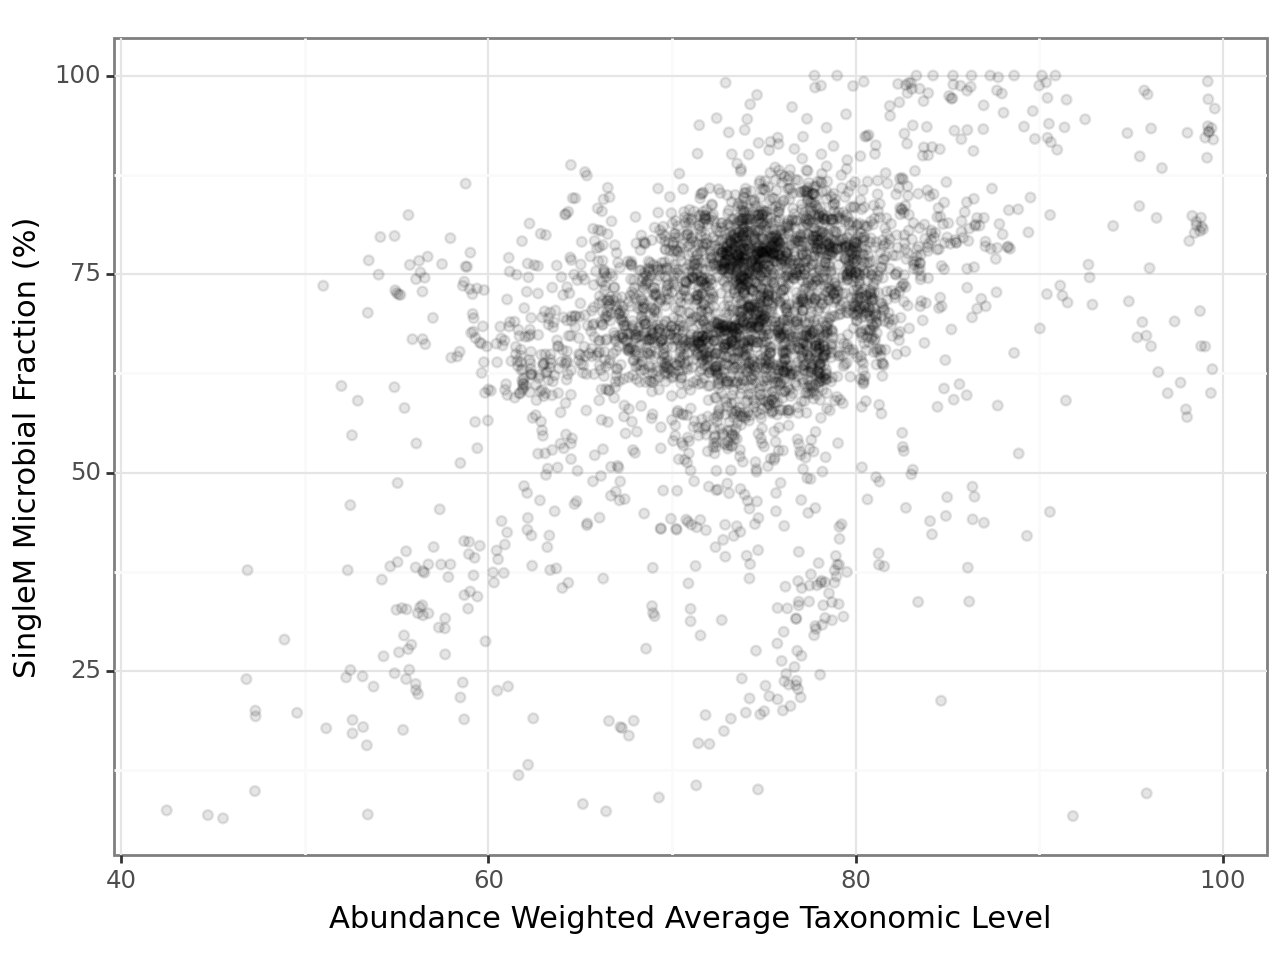

<Figure Size: (640 x 480)>

In [170]:
level_to_rank = {l: float(i)/(len(level_order)-1) for i, l in enumerate(level_order)}
level_to_rank
cl = soil_classification_rates.with_columns(pl.col('level').map_elements(lambda x: level_to_rank[x]))
cl = cl.with_columns(pl.col('relative abundance (%)').alias('weighted_ave_level')*pl.col('level'))

cl = cl.select(['sample', 'weighted_ave_level']).group_by('sample').sum()
clsll = cl.join(sll, left_on='sample', right_on='acc', how='inner')
clsll[:10]

ggplot(clsll)+geom_point(aes(x='weighted_ave_level', y='smf'), alpha=0.1)+ylab('SingleM Microbial Fraction (%)')+xlab('Abundance Weighted Average Taxonomic Level')